In [2]:
# !pip install --no-cache-dir jupyter-black
# !pip install --no-cache-dir 'numpy<2'
# !pip install --no-cache-dir fiona==1.9.6
# !pip install --no-cache-dir python-box

In [1]:
%load_ext jupyter_black

In [2]:
from pathlib import Path
from typing import Union

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

import shapely
import stackstac
import pystac_client

from shapely import wkt
from tqdm import tqdm
from rasterio.enums import Resampling
from dataclasses import dataclass

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
@dataclass(frozen=True)
class SCL:
    NO_DATA: int = 0
    SATURATED_OR_DEFECTIVE: int = 1
    DARK_AREA_PIXELS: int = 2
    CLOUD_SHADOWS: int = 3
    VEGETATION: int = 4
    NOT_VEGETATED: int = 5
    WATER: int = 6
    UNCLASSIFIED: int = 7
    CLOUD_MEDIUM_PROBABILITY: int = 8
    CLOUD_HIGH_PROBABILITY: int = 9
    THIN_CIRRUS: int = 10
    SNOW: int = 11

In [5]:
def stac_items_search(
    bbox_wgs, start_date, end_date, max_items=512, cloud_cover_cover_max=70
):
    # Search the catalogue
    catalog = pystac_client.Client.open(STAC_API)
    search = catalog.search(
        collections=[COLLECTION],
        datetime=f"{start_date}/{end_date}",
        bbox=bbox_wgs,
        max_items=max_items,
        query={
            "eo:cloud_cover": {"lt": cloud_cover_cover_max},
            # "sentinel:valid_cloud_cover": {"eq": True},
        },
        fields=[
            "id",
            "type",
            "geometry",
            "properties.eo:cloud_cover",
            "properties.proj:epsg",
            "properties.proj:transform",
            "properties.sentinel:valid_cloud_cover",
        ],
    )

    all_items = search.get_all_items()

    for item in all_items:
        cloud_cover = item.properties.get("eo:cloud_cover", None)
        if cloud_cover is None:
            print(f"Warning: Missing 'eo:cloud_cover' for item {item.id}")

    # Reduce to one per date (there might be some duplicates
    # based on the location)
    items = []
    dates = []
    for item in all_items:
        if item.datetime.date() not in dates:
            items.append(item)
            dates.append(item.datetime.date())

    items = [item for item in items if "eo:cloud_cover" in item.properties]

    return items


def stac_items_compute(items, bbox, bands):
    gsd = 10  # [m/px]
    epsg = items[0].properties["proj:epsg"]

    # Retrieve the pixel values, for the bounding box in
    # the target projection. In this example we use only
    # the RGB and NIR bands.
    stack = stackstac.stack(
        items,
        bounds=bbox,
        snap_bounds=False,
        epsg=epsg,
        resolution=gsd,
        dtype="float32",
        rescale=False,
        fill_value=np.float32(0),
        assets=bands,
        resampling=Resampling.nearest,
    )
    return stack


def get_bbox(gdf, buffer_m=10):
    gdf_buf = gdf.to_crs(gdf.estimate_utm_crs())
    gdf_buf["geometry"] = gdf_buf["geometry"].buffer(buffer_m)
    gdf_buf = gdf_buf.to_crs("EPSG:4326")
    lon, lat = gdf_buf["geometry"].iloc[0].centroid.xy

    bbox = gdf_buf.to_crs(gdf_buf.estimate_utm_crs())["geometry"].iloc[0].bounds
    bbox_wgs = gdf_buf["geometry"].iloc[0].bounds
    lat = lat[0]
    lon = lon[0]
    return lon, lat, bbox, bbox_wgs, max(bbox[2] - bbox[0], bbox[3] - bbox[1])


def prepare_datacube(
    sample: dict,
    max_items: int = 2048,
    cloud_cover_cover_max: float = 70,
    buffer_m: float = 0,
) -> dict:
    bands = [
        "blue",
        "green",
        "red",
        "nir",
        "nir08",
        "swir16",
        "scl",
    ]
    grove_geom = gpd.GeoDataFrame(
        [
            {
                "geometry": (
                    wkt.loads(sample["geometry"])
                    if isinstance(sample["geometry"], str)
                    else sample["geometry"]
                )
            }
        ],
        crs="EPSG:4326",
        geometry="geometry",
    )
    lon, lat, bbox, bbox_wgs, largest_side = get_bbox(grove_geom, buffer_m=buffer_m)

    end_date = sample["end_date"]
    start_date = sample["start_date"]
    items = stac_items_search(
        bbox_wgs,
        start_date,
        end_date,
        max_items=max_items,
        cloud_cover_cover_max=cloud_cover_cover_max,
    )
    # items = [item for item in items if "eo:cloud_cover" in item.properties]
    if len(items) == 0:
        return None
    stack = stac_items_compute(items, bbox, bands)
    return stack


def add_band_to_dataarray(data, new_band, band_name):
    """
    Adds a new band to an existing xarray.DataArray.

    Parameters:
    - data (xr.DataArray): Original DataArray with shape (time, bands, x, y).
    - new_band (xr.DataArray): New DataArray with shape (time, x, y).
    - band_name (str): Name of the new band to add.

    Returns:
    - xr.DataArray: Updated DataArray with the new band added.
    """
    # Check dimensions of the input DataArray
    if "band" not in data.dims:
        raise ValueError("Input DataArray must have a 'band' dimension.")

    if set(new_band.dims) != {"time", "x", "y"}:
        raise ValueError("New band must have dimensions ('time', 'x', 'y').")

    new_band = new_band.assign_coords(
        title=None,
        common_name=band_name,
        center_wavelength=None,
        full_width_half_max=None,
    )
    if "gsd" not in new_band.coords:
        new_band = new_band.assign_coords(gsd=10)

    if "raster:bands" in data.coords and "raster:bands" not in new_band.coords:
        new_band = new_band.assign_coords({"raster:bands": None})

    # Expand the new_band along the 'band' dimension
    new_band_expanded = new_band.expand_dims(dim={"band": [band_name]}, axis=1)

    # Concatenate along the 'band' dimension
    updated_data = xr.concat([data, new_band_expanded], dim="band")

    return updated_data


def rename_bands(data, band_mapping):
    """
    Rename bands in an xarray.DataArray based on a provided mapping.

    Parameters:
    - data (xr.DataArray): Input DataArray with a 'band' dimension.
    - band_mapping (dict): Dictionary mapping old band names to new band names.

    Returns:
    - xr.DataArray: DataArray with renamed bands.
    """
    # Ensure the 'band' dimension exists in the DataArray
    if "band" not in data.dims:
        raise ValueError("'band' dimension not found in the DataArray.")

    # Check that the band names to rename exist in the DataArray
    missing_bands = [
        band for band in band_mapping.keys() if band not in data.coords["band"].values
    ]
    if missing_bands:
        raise ValueError(
            f"The following bands are not in the DataArray: {missing_bands}"
        )

    # Rename the bands using the mapping
    new_band_coords = [
        band_mapping[band] if band in band_mapping else band
        for band in data.coords["band"].values
    ]
    data = data.assign_coords(band=new_band_coords)
    return data


def compute_bands(stack):
    red = stack.sel(band="red")
    nir = stack.sel(band="nir")
    green = stack.sel(band="green")
    swir16 = stack.sel(band="swir16")
    blue = stack.sel(band="blue")
    scl = stack.sel(band="scl")
    L = 0.5

    stack = add_band_to_dataarray(stack, (nir - red) / (nir + red), "ndvi")
    stack = add_band_to_dataarray(stack, (nir - swir16) / (nir + swir16), "ndwi")
    stack = add_band_to_dataarray(
        stack, 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1), "evi"
    )
    stack = add_band_to_dataarray(stack, (nir - green) / (nir + green), "gndvi")
    stack = add_band_to_dataarray(
        stack, ((nir - red) * (1 + L)) / (nir + red + L), "savi"
    )
    stack = add_band_to_dataarray(
        stack,
        (
            (scl != SCL.CLOUD_MEDIUM_PROBABILITY)
            & (scl != SCL.CLOUD_HIGH_PROBABILITY)
            & (scl != SCL.THIN_CIRRUS)
            & (scl != SCL.CLOUD_SHADOWS)
        ),
        "scl_cls",
    )
    stack = add_band_to_dataarray(
        stack,
        (scl == SCL.VEGETATION),
        "veg_frac",
    )
    stack = add_band_to_dataarray(
        stack,
        (scl == SCL.NOT_VEGETATED),
        "notveg_frac",
    )
    stack = stack.sel(band=stack.band != "scl")
    stat_band_names = list(stack.band.values)
    return stack, stat_band_names

crs=EPSG:2154


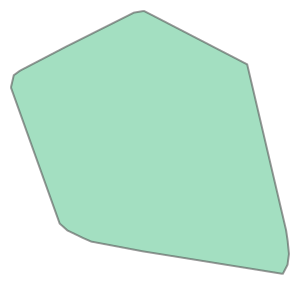

In [6]:
# gdf = gpd.read_file(
#     "/home/vkh/Downloads/v_khramtsov_manage-operation-hot_stagesPipeline_SCGC_Big_B_Sugar_Corporation_Tesoro_SCGC_Big_B_Sugar_Corporation_Tesoro_East_Tesoro-East_2025_01_20_Merge_1_2_1-08_P_11E_generalizedAutorowsInferenceTask_detected_rows.geojson"
# )
# gdf = gpd.read_file(
#     "/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/uk_fields_tiles_chosen_subset_5km.geojson"
# )
gdf = gpd.read_file(
    "/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/france_fields_tiles_chosen_subset_5km.geojson"
)
gdf = gdf[["geometry"]]
crs = gdf.crs
print(f"crs={crs}")
# assert crs == "epsg:27700"
assert crs == "epsg:2154"

geometry = shapely.ops.unary_union(gdf["geometry"].to_list()).convex_hull
geometry

In [7]:
gdf.to_crs("EPSG:4326", inplace=True)

In [8]:
gdf.head()

,geometry
0,"POLYGON ((-1.11878 47.33108, -1.12569 47.42098..."
1,"POLYGON ((6.37233 45.25335, 6.37779 45.34331, ..."
2,"POLYGON ((0.10647 46.62036, 0.10167 46.71034, ..."
3,"POLYGON ((-1.75481 47.16217, -1.76277 47.25203..."
4,"POLYGON ((4.55743 44.13262, 4.5599 44.22261, 4..."


In [9]:
geometry = gdf["geometry"].iloc[0].convex_hull
print(f"First tile area: {geometry.area}")

First tile area: 0.003356744894505598


In [33]:
sample = {"geometry": geometry, "start_date": "2018-02-25", "end_date": "2018-06-07"}
# stack = prepare_datacube(sample, max_items=1024, cloud_cover_cover_max=20, buffer_m=250)
stack = prepare_datacube(sample, max_items=1024, cloud_cover_cover_max=40, buffer_m=250)

/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


In [34]:
stack

<xarray.DataArray 'stackstac-1243d5f0537985a23caf411611c41503' (time: 10,
                                                                band: 7,
                                                                y: 1124, x: 1124)> Size: 354MB
dask.array<fetch_raster_window, shape=(10, 7, 1124, 1124), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time                 (time) datetime64[ns] 80B 2018-03-20T11:07:57.519000...
    id                   (time) <U24 960B 'S2B_30TXT_20180320_1_L2A' ... 'S2A...
  * band                 (band) <U6 168B 'blue' 'green' 'red' ... 'swir16' 'scl'
  * x                    (x) float64 9kB 6.311e+05 6.312e+05 ... 6.424e+05
  * y                    (y) float64 9kB 5.254e+06 5.254e+06 ... 5.243e+06
    eo:cloud_cover       (time) float64 80B 15.12 0.2527 ... 2.101 25.17
    ...                   ...
    title                (band) <U30 840B 'Blue (band 2) - 10m' ... 'Scene cl...
    raster:bands         (band) object 56B None ... [{'data_type': 'uint8', '...
    common_name          (band) object 56B 'blue' 'green' ... 'swir16' None
    center_wavelength    (band) object 56B 0.49 0.56 0.665 0.842 0.865 1.61 None
    full_width_half_max  (band) object 56B 0.098 0.045 0.038 ... 0.143 None
    epsg                 int64 8B 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(631142.8995340845, 5242660.17...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 631142.90|\n| 0.00,-10.00, 5253900.50|\n| 0.0...
    resolution:  10

In [35]:
len(stack.time)

10

In [46]:
stack, stat_band_names = compute_bands(stack)
stack

<xarray.DataArray 'stackstac-53face68924ad0608515d47c68622358' (time: 4,
                                                                band: 14,
                                                                y: 1116, x: 1116)> Size: 279MB
dask.array<getitem, shape=(4, 14, 1116, 1116), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time                 (time) datetime64[ns] 32B 2021-05-31T11:16:44.008000...
    id                   (time) <U24 384B 'S2A_31UCT_20210531_0_L2A' ... 'S2A...
  * band                 (band) object 112B 'blue' 'green' ... 'notveg_frac'
  * x                    (x) float64 9kB 3.811e+05 3.811e+05 ... 3.923e+05
  * y                    (y) float64 9kB 5.809e+06 5.809e+06 ... 5.798e+06
    eo:cloud_cover       (time) float64 32B 0.2381 34.14 34.39 9.611
    ...                   ...
    gsd                  (band) object 112B 10 10 10 10 20 ... 10 None None None
    title                (band) object 112B 'Blue (band 2) - 10m' ... None
    common_name          (band) object 112B 'blue' 'green' ... 'notveg_frac'
    center_wavelength    (band) object 112B 0.49 0.56 0.665 ... None None None
    full_width_half_max  (band) object 112B 0.098 0.045 0.038 ... None None None
    epsg                 int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(381127.94641279476, 5797820.7...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 381127.95|\n| 0.00,-10.00, 5808982.04|\n| 0.0...
    resolution:  10

In [59]:
stack["raster:bands"].values.shape[0]

14

In [47]:
array = stack.values
# T C H W
array.shape

(4, 14, 1116, 1116)

In [48]:
import yaml
from box import Box


def read_sentinel2_metainfo(bands: list, metadata_path=""):
    metadata = Box(yaml.safe_load(open("./satconfig.yaml")))
    platform = "sentinel-2-l2a"

    mean = []
    std = []
    waves = []
    # Use the band names to get the correct values in the correct order.
    for band in [b for b in bands if b != "scl"]:
        mean.append(metadata[platform].bands.mean[band])
        std.append(metadata[platform].bands.std[band])
        waves.append(metadata[platform].bands.wavelength[band])
    return mean, std, waves


bands = [
    "blue",
    "green",
    "red",
    "nir",
    "nir08",
    "swir16",
]
mean, std, waves = read_sentinel2_metainfo(bands=bands)
sentinel2_metainfo = pd.DataFrame(
    {"bands": bands, "mean": mean, "std": std, "waves": waves}
)
sentinel2_metainfo

,bands,mean,std,waves
0,blue,1105.0,1809.0,0.493
1,green,1355.0,1757.0,0.560
2,red,1552.0,1888.0,0.665
3,nir,2743.0,1742.0,0.842
4,nir08,2785.0,1648.0,0.865
5,swir16,2388.0,1470.0,1.610


In [49]:
array[0].shape

(14, 1116, 1116)

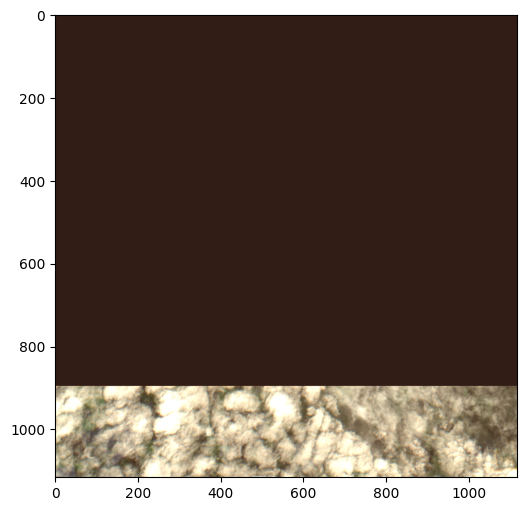

In [54]:
import matplotlib.pyplot as plt

mean = sentinel2_metainfo["mean"].iloc[:3].to_numpy()
std = sentinel2_metainfo["std"].iloc[:3].to_numpy()

scale = lambda x: ((x - mean) / std + 1) / 2

# plt.figure(figsize=(6, 6))
# plt.imshow(scale(array[1, :3].transpose(1, 2, 0)))
# plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(scale(array[2, :3].transpose(1, 2, 0)))
plt.show()

## Save stack

In [8]:
import rioxarray
import rasterio


def save_stack(stack: xr.core.dataarray.DataArray, save_path: Union[str, Path]):

    # Assume 'stack' is your DataArray
    # Step 1: Find the time index with the least cloud coverage
    best_time_index = stack["eo:cloud_cover"].argmin().item()

    # Step 2: Select the best time slice
    selected_stack = stack.sel(time=stack.time[best_time_index])

    # Step 3: Ensure CRS is set correctly
    selected_stack.rio.write_crs(stack.crs, inplace=True)

    # Step 4: Save as GeoTIFF
    selected_stack.rio.to_raster(Path(save_path).as_posix(), dtype="float32")


def save_stack(stack: xr.DataArray, save_path: Union[str, Path]):
    if "eo:cloud_cover" in stack.coords:
        # Step 1: Find the time index with the least cloud coverage
        best_time_index = stack["eo:cloud_cover"].argmin().item()

        # Step 2: Select the best time slice
        selected_stack = stack.sel(time=stack.time[best_time_index])
    else:
        selected_stack = stack.sel(time=stack.time[0])

    # Step 3: Extract the acquisition date
    acquisition_date = pd.to_datetime(selected_stack.time.item()).strftime(
        "%Y-%m-%d %H:%M:%S"
    )

    # Step 4: Ensure CRS is set correctly
    selected_stack.rio.write_crs(stack.crs, inplace=True)

    # Step 5: Save as GeoTIFF with metadata
    metadata = {"DATE": acquisition_date}

    with rasterio.Env():  # Ensure the metadata is written
        selected_stack.rio.to_raster(
            Path(save_path).as_posix(),
            dtype="float32",
            tags=metadata,  # Embed acquisition date in metadata
        )

    # print(f"Saved TIFF with acquisition date: {acquisition_date}")

In [12]:
stacks_dir = Path(
    "/Users/Shared/Quantum/Projects/plot_boundary_detection/data/satellite_imagery/sentinel/uk_fields_5km"
)
stacks_dir.mkdir(exist_ok=True, parents=True)

empty_stacks_count = 0
saved_stacks_count = 0
for i, geom in tqdm(
    enumerate(gdf["geometry"]), total=gdf.shape[0], desc="Extract stacks:"
):
    # print(f"Index: {i}")
    sample = {
        "geometry": geom.convex_hull,
        "start_date": "2021-05-15",
        "end_date": "2021-06-17",
    }
    stack = prepare_datacube(
        sample, max_items=1024, cloud_cover_cover_max=25, buffer_m=250
    )

    if stack is None or len(stack.time) == 0:
        empty_stacks_count += 1
        continue

    stack_path = stacks_dir / f"{str(i).zfill(4)}.tif"
    try:
        save_stack(stack, stack_path)
    except KeyError as ke:
        print("Cannot save stack. Skipping")
        empty_stacks_count += 1
        continue
    saved_stacks_count += 1

print(f"#Saved stacks: {saved_stacks_count}")
print(f"#Empty stacks: {empty_stacks_count}")

Extract stacks::   0%|                                                                                                                        | 0/1191 [00:00<?, ?it/s]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks::   0%|                                                                                                              | 1/1191 [00:06<2:16:08,  6.86s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks::   0%|▏                                                                                                             | 2/1191 [00:12<1:56:01,  5.85s/it]/Users/Shared/Quantum/Projects/pl

#Saved stacks: 946
#Empty stacks: 245


In [9]:
stacks_dir = Path(
    "/Users/Shared/Quantum/Projects/plot_boundary_detection/data/satellite_imagery/sentinel/france_fields_5km"
)
stacks_dir.mkdir(exist_ok=True, parents=True)

empty_stacks_count = 0
saved_stacks_count = 0
for i, geom in tqdm(
    enumerate(gdf["geometry"]), total=gdf.shape[0], desc="Extract stacks for France"
):
    # print(f"Index: {i}")
    sample = {
        "geometry": geom.convex_hull,
        "start_date": "2017-11-15",
        "end_date": "2018-03-15",
    }
    stack = prepare_datacube(
        sample, max_items=1024, cloud_cover_cover_max=40, buffer_m=250
    )

    if stack is None or len(stack.time) == 0:
        print(f"Empty stack: {i}")
        empty_stacks_count += 1
        continue

    stack_path = stacks_dir / f"{str(i).zfill(4)}.tif"
    try:
        save_stack(stack, stack_path)
    except KeyError as ke:
        print(f"Cannot save stack due to error {ke}. Skipping")
        empty_stacks_count += 1
        continue
    saved_stacks_count += 1

print(f"#Saved stacks: {saved_stacks_count}")
print(f"#Empty stacks: {empty_stacks_count}")

Extract stacks for France:   0%|                                                                                                              | 0/2373 [00:00<?, ?it/s]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   0%|                                                                                                    | 1/2373 [00:07<4:57:37,  7.53s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   0%|                                                                                                    | 2/2373 [00:11<3:24:03,  5.16s/it]/Users/Shared/Quantum/Projects/pl

Empty stack: 4


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   0%|▎                                                                                                   | 6/2373 [00:21<1:49:22,  2.77s/it]

Empty stack: 5


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   0%|▎                                                                                                   | 7/2373 [00:22<1:25:34,  2.17s/it]

Empty stack: 6


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   0%|▎                                                                                                   | 8/2373 [00:28<2:15:55,  3.45s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   0%|▍                                                                                                   | 9/2373 [00:37<3:23:09,  5.16s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 9


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   0%|▍                                                                                                  | 11/2373 [00:46<3:22:57,  5.16s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   1%|▌                                                                                                  | 12/2373 [00:52<3:30:55,  5.36s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 18


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   1%|▊                                                                                                  | 20/2373 [01:33<2:59:52,  4.59s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   1%|▉                                                                                                  | 21/2373 [01:39<3:12:00,  4.90s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 25


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   1%|█▏                                                                                                 | 27/2373 [02:15<3:57:12,  6.07s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   1%|█▏                                                                                                 | 28/2373 [02:16<2:56:50,  4.52s/it]

Empty stack: 27


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   1%|█▏                                                                                                 | 29/2373 [02:17<2:14:55,  3.45s/it]

Empty stack: 28


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   1%|█▎                                                                                                 | 30/2373 [02:27<3:34:24,  5.49s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   1%|█▎                                                                                                 | 31/2373 [02:34<3:49:29,  5.88s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 34


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   2%|█▌                                                                                                 | 36/2373 [03:02<3:25:39,  5.28s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   2%|█▌                                                                                                 | 37/2373 [03:06<3:18:42,  5.10s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 37


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   2%|█▋                                                                                                 | 39/2373 [03:11<2:25:29,  3.74s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   2%|█▋                                                                                                 | 40/2373 [03:13<2:02:34,  3.15s/it]

Empty stack: 39


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   2%|█▋                                                                                                 | 41/2373 [03:14<1:48:00,  2.78s/it]

Empty stack: 40


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   2%|█▊                                                                                                 | 42/2373 [03:15<1:26:26,  2.23s/it]

Empty stack: 41


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   2%|█▊                                                                                                 | 43/2373 [03:17<1:16:44,  1.98s/it]

Empty stack: 42


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   2%|█▊                                                                                                 | 44/2373 [03:18<1:04:38,  1.67s/it]

Empty stack: 43


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   2%|█▉                                                                                                 | 45/2373 [03:23<1:42:16,  2.64s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   2%|█▉                                                                                                 | 46/2373 [03:29<2:22:50,  3.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 57


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   2%|██▍                                                                                                | 59/2373 [04:47<4:25:31,  6.88s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   3%|██▌                                                                                                | 60/2373 [04:54<4:29:10,  6.98s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 61


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   3%|██▋                                                                                                | 63/2373 [05:02<2:33:30,  3.99s/it]

Empty stack: 62


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   3%|██▋                                                                                                | 64/2373 [05:08<2:49:25,  4.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   3%|██▋                                                                                                | 65/2373 [05:13<2:59:56,  4.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 66


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   3%|██▊                                                                                                | 68/2373 [05:19<1:46:40,  2.78s/it]

Empty stack: 67


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   3%|██▉                                                                                                | 69/2373 [05:24<2:10:41,  3.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   3%|██▉                                                                                                | 70/2373 [05:28<2:16:17,  3.55s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 71


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   3%|███                                                                                                | 73/2373 [05:37<2:03:37,  3.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   3%|███                                                                                                | 74/2373 [05:41<2:09:36,  3.38s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 75


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   3%|███▏                                                                                               | 77/2373 [05:52<2:20:00,  3.66s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   3%|███▎                                                                                               | 78/2373 [05:57<2:37:05,  4.11s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 82


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   4%|███▌                                                                                               | 84/2373 [06:23<2:43:27,  4.28s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   4%|███▌                                                                                               | 85/2373 [06:25<2:09:47,  3.40s/it]

Empty stack: 84


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   4%|███▌                                                                                               | 86/2373 [06:29<2:21:00,  3.70s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   4%|███▋                                                                                               | 87/2373 [06:34<2:38:36,  4.16s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 88


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   4%|███▊                                                                                               | 90/2373 [06:46<2:31:49,  3.99s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   4%|███▊                                                                                               | 91/2373 [06:53<3:05:14,  4.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 95


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   4%|████                                                                                               | 97/2373 [07:17<2:16:29,  3.60s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   4%|████                                                                                               | 98/2373 [07:19<2:01:12,  3.20s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 104


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   4%|████▍                                                                                             | 106/2373 [08:07<3:10:55,  5.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|████▍                                                                                             | 107/2373 [08:08<2:33:37,  4.07s/it]

Empty stack: 106


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|████▍                                                                                             | 108/2373 [08:13<2:40:54,  4.26s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|████▌                                                                                             | 109/2373 [08:17<2:39:31,  4.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 111


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|████▋                                                                                             | 113/2373 [08:31<2:15:01,  3.58s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|████▋                                                                                             | 114/2373 [08:33<1:56:33,  3.10s/it]

Empty stack: 113


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|████▋                                                                                             | 115/2373 [08:38<2:18:58,  3.69s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|████▊                                                                                             | 116/2373 [08:42<2:24:41,  3.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 119


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|████▉                                                                                             | 121/2373 [09:04<2:45:58,  4.42s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|█████                                                                                             | 122/2373 [09:09<3:00:54,  4.82s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 124


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|█████▏                                                                                            | 126/2373 [09:20<1:42:04,  2.73s/it]

Empty stack: 125


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|█████▏                                                                                            | 127/2373 [09:30<3:11:53,  5.13s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|█████▎                                                                                            | 128/2373 [09:35<3:09:44,  5.07s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 128


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   5%|█████▎                                                                                            | 130/2373 [09:42<2:48:34,  4.51s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   6%|█████▍                                                                                            | 131/2373 [09:48<2:57:38,  4.75s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 131


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   6%|█████▍                                                                                            | 133/2373 [09:54<2:37:23,  4.22s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   6%|█████▌                                                                                            | 134/2373 [09:59<2:45:38,  4.44s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 144


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   6%|██████                                                                                            | 146/2373 [10:46<2:16:15,  3.67s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   6%|██████                                                                                            | 147/2373 [10:50<2:17:03,  3.69s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 154


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   7%|██████▍                                                                                           | 156/2373 [11:36<2:48:12,  4.55s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   7%|██████▍                                                                                           | 157/2373 [11:42<3:04:13,  4.99s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 157


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   7%|██████▌                                                                                           | 159/2373 [11:48<2:37:12,  4.26s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   7%|██████▌                                                                                           | 160/2373 [11:56<3:12:04,  5.21s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 160


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   7%|██████▋                                                                                           | 162/2373 [12:02<2:41:04,  4.37s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   7%|██████▋                                                                                           | 163/2373 [12:08<2:59:14,  4.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 167


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   7%|██████▉                                                                                           | 169/2373 [12:34<2:07:29,  3.47s/it]

Empty stack: 168


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   7%|███████                                                                                           | 170/2373 [12:42<2:51:23,  4.67s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   7%|███████                                                                                           | 171/2373 [12:44<2:19:30,  3.80s/it]

Empty stack: 170


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   7%|███████                                                                                           | 172/2373 [12:49<2:41:23,  4.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   7%|███████▏                                                                                          | 173/2373 [12:53<2:34:45,  4.22s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 179


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|███████▍                                                                                          | 181/2373 [13:26<2:15:19,  3.70s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|███████▌                                                                                          | 182/2373 [13:31<2:27:22,  4.04s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 183


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|███████▋                                                                                          | 185/2373 [13:45<2:53:22,  4.75s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|███████▋                                                                                          | 186/2373 [13:56<3:57:21,  6.51s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 186


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|███████▊                                                                                          | 188/2373 [14:02<3:01:37,  4.99s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|███████▊                                                                                          | 189/2373 [14:03<2:20:47,  3.87s/it]

Empty stack: 188


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|███████▊                                                                                          | 190/2373 [14:05<1:51:54,  3.08s/it]

Empty stack: 189


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|███████▉                                                                                          | 191/2373 [14:09<2:09:06,  3.55s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|███████▉                                                                                          | 192/2373 [14:16<2:43:05,  4.49s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 194


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|████████                                                                                          | 196/2373 [14:30<2:06:14,  3.48s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|████████▏                                                                                         | 197/2373 [14:31<1:41:13,  2.79s/it]

Empty stack: 196


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|████████▏                                                                                         | 198/2373 [14:36<1:58:37,  3.27s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|████████▏                                                                                         | 199/2373 [14:39<1:57:55,  3.25s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 199


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   8%|████████▎                                                                                         | 201/2373 [14:43<1:32:03,  2.54s/it]

Empty stack: 200


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   9%|████████▎                                                                                         | 202/2373 [14:47<1:55:36,  3.20s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   9%|████████▍                                                                                         | 203/2373 [14:51<2:02:15,  3.38s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 207


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   9%|████████▋                                                                                         | 209/2373 [15:12<1:49:12,  3.03s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   9%|████████▋                                                                                         | 210/2373 [15:16<2:03:38,  3.43s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 210


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   9%|████████▊                                                                                         | 212/2373 [15:22<2:01:56,  3.39s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   9%|████████▊                                                                                         | 213/2373 [15:25<1:59:37,  3.32s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 221


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   9%|█████████▏                                                                                        | 223/2373 [16:13<1:42:55,  2.87s/it]

Empty stack: 222


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   9%|█████████▎                                                                                        | 224/2373 [16:15<1:32:38,  2.59s/it]

Empty stack: 223


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:   9%|█████████▎                                                                                        | 225/2373 [16:16<1:17:52,  2.18s/it]

Empty stack: 224


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|█████████▎                                                                                        | 226/2373 [16:20<1:39:49,  2.79s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|█████████▎                                                                                        | 227/2373 [16:21<1:19:37,  2.23s/it]

Empty stack: 226


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|█████████▍                                                                                        | 228/2373 [16:25<1:39:55,  2.79s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|█████████▍                                                                                        | 229/2373 [16:35<2:52:37,  4.83s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 230


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|█████████▌                                                                                        | 232/2373 [16:45<2:24:23,  4.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|█████████▌                                                                                        | 233/2373 [16:50<2:32:37,  4.28s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 235


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|█████████▊                                                                                        | 237/2373 [17:14<3:27:13,  5.82s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|█████████▊                                                                                        | 238/2373 [17:20<3:32:08,  5.96s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 238


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|█████████▉                                                                                        | 240/2373 [17:29<3:12:13,  5.41s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|█████████▉                                                                                        | 241/2373 [17:33<2:59:17,  5.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 243


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|██████████                                                                                        | 245/2373 [17:47<2:14:42,  3.80s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|██████████▏                                                                                       | 246/2373 [17:52<2:29:51,  4.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 246


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|██████████▏                                                                                       | 248/2373 [18:05<3:27:55,  5.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  10%|██████████▎                                                                                       | 249/2373 [18:06<2:39:44,  4.51s/it]

Empty stack: 248


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  11%|██████████▎                                                                                       | 250/2373 [18:08<2:04:44,  3.53s/it]

Empty stack: 249


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  11%|██████████▎                                                                                       | 251/2373 [18:12<2:17:05,  3.88s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  11%|██████████▍                                                                                       | 252/2373 [18:15<2:07:07,  3.60s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 253


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  11%|██████████▌                                                                                       | 255/2373 [18:29<2:34:07,  4.37s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  11%|██████████▌                                                                                       | 256/2373 [18:34<2:38:36,  4.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 271


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  12%|███████████▎                                                                                      | 273/2373 [20:14<3:39:45,  6.28s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  12%|███████████▎                                                                                      | 274/2373 [20:22<3:59:57,  6.86s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 279


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  12%|███████████▌                                                                                      | 281/2373 [20:44<1:34:19,  2.71s/it]

Empty stack: 280


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  12%|███████████▋                                                                                      | 282/2373 [20:48<1:39:06,  2.84s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  12%|███████████▋                                                                                      | 283/2373 [20:49<1:18:59,  2.27s/it]

Empty stack: 282


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  12%|███████████▋                                                                                      | 284/2373 [20:54<1:50:03,  3.16s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  12%|███████████▊                                                                                      | 285/2373 [20:58<1:59:50,  3.44s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 290


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  12%|████████████                                                                                      | 292/2373 [21:30<2:16:41,  3.94s/it]

Empty stack: 291


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  12%|████████████                                                                                      | 293/2373 [21:32<1:58:34,  3.42s/it]

Empty stack: 292


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  12%|████████████▏                                                                                     | 294/2373 [21:38<2:31:28,  4.37s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  12%|████████████▏                                                                                     | 295/2373 [21:42<2:25:01,  4.19s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 295


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|████████████▎                                                                                     | 297/2373 [21:47<1:56:26,  3.37s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|████████████▎                                                                                     | 298/2373 [21:52<2:17:53,  3.99s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 300


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|████████████▍                                                                                     | 302/2373 [22:15<2:13:50,  3.88s/it]

Empty stack: 301


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|████████████▌                                                                                     | 303/2373 [22:19<2:17:09,  3.98s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|████████████▌                                                                                     | 304/2373 [22:24<2:25:31,  4.22s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 304


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|████████████▋                                                                                     | 306/2373 [22:26<1:33:14,  2.71s/it]

Empty stack: 305


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|████████████▋                                                                                     | 307/2373 [22:38<3:06:29,  5.42s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|████████████▋                                                                                     | 308/2373 [22:40<2:27:09,  4.28s/it]

Empty stack: 307


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|████████████▊                                                                                     | 309/2373 [22:45<2:40:32,  4.67s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|████████████▊                                                                                     | 310/2373 [22:49<2:33:12,  4.46s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 311


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|████████████▉                                                                                     | 313/2373 [22:59<2:03:53,  3.61s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|████████████▉                                                                                     | 314/2373 [23:03<2:09:42,  3.78s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 315


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|█████████████                                                                                     | 317/2373 [23:12<1:56:38,  3.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  13%|█████████████▏                                                                                    | 318/2373 [23:16<2:02:20,  3.57s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 319


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  14%|█████████████▎                                                                                    | 321/2373 [23:22<1:20:39,  2.36s/it]

Empty stack: 320


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  14%|█████████████▎                                                                                    | 322/2373 [23:27<1:46:46,  3.12s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  14%|█████████████▎                                                                                    | 323/2373 [23:32<2:09:46,  3.80s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 334


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  14%|█████████████▉                                                                                    | 336/2373 [24:36<2:31:36,  4.47s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  14%|█████████████▉                                                                                    | 337/2373 [24:37<1:59:14,  3.51s/it]

Empty stack: 336


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  14%|█████████████▉                                                                                    | 338/2373 [24:39<1:43:24,  3.05s/it]

Empty stack: 337


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  14%|██████████████                                                                                    | 339/2373 [24:46<2:23:25,  4.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  14%|██████████████                                                                                    | 340/2373 [24:47<1:52:25,  3.32s/it]

Empty stack: 339


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  14%|██████████████                                                                                    | 341/2373 [24:52<2:08:59,  3.81s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  14%|██████████████                                                                                    | 342/2373 [24:54<1:52:24,  3.32s/it]

Empty stack: 341


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  14%|██████████████▏                                                                                   | 343/2373 [24:59<2:03:55,  3.66s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  14%|██████████████▏                                                                                   | 344/2373 [25:06<2:38:08,  4.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 344


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▎                                                                                   | 346/2373 [25:14<2:29:41,  4.43s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▎                                                                                   | 347/2373 [25:15<1:59:09,  3.53s/it]

Empty stack: 346


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▎                                                                                   | 348/2373 [25:23<2:38:49,  4.71s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▍                                                                                   | 349/2373 [25:29<2:55:31,  5.20s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 349


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▍                                                                                   | 351/2373 [25:31<1:46:55,  3.17s/it]

Empty stack: 350


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▌                                                                                   | 352/2373 [25:33<1:35:53,  2.85s/it]

Empty stack: 351


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▌                                                                                   | 353/2373 [25:39<2:01:55,  3.62s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▌                                                                                   | 354/2373 [25:41<1:44:03,  3.09s/it]

Empty stack: 353


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▋                                                                                   | 355/2373 [25:43<1:32:24,  2.75s/it]

Empty stack: 354


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▋                                                                                   | 356/2373 [25:44<1:17:09,  2.30s/it]

Empty stack: 355


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▋                                                                                   | 357/2373 [25:50<1:58:03,  3.51s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▊                                                                                   | 358/2373 [25:55<2:11:51,  3.93s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 361


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|██████████████▉                                                                                   | 363/2373 [26:13<1:56:04,  3.47s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|███████████████                                                                                   | 364/2373 [26:14<1:37:29,  2.91s/it]

Empty stack: 363


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|███████████████                                                                                   | 365/2373 [26:18<1:43:19,  3.09s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|███████████████                                                                                   | 366/2373 [26:20<1:31:02,  2.72s/it]

Empty stack: 365


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  15%|███████████████▏                                                                                  | 367/2373 [26:23<1:42:27,  3.06s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▏                                                                                  | 368/2373 [26:25<1:26:43,  2.60s/it]

Empty stack: 367


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▏                                                                                  | 369/2373 [26:38<3:13:03,  5.78s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▎                                                                                  | 370/2373 [26:39<2:28:09,  4.44s/it]

Empty stack: 369


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▎                                                                                  | 371/2373 [26:46<2:45:51,  4.97s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▎                                                                                  | 372/2373 [26:49<2:31:49,  4.55s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 375


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▌                                                                                  | 377/2373 [27:11<2:46:18,  5.00s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▌                                                                                  | 378/2373 [27:12<2:05:22,  3.77s/it]

Empty stack: 377


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▋                                                                                  | 379/2373 [27:23<3:10:43,  5.74s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▋                                                                                  | 380/2373 [27:25<2:32:42,  4.60s/it]

Empty stack: 379


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▋                                                                                  | 381/2373 [27:27<2:07:41,  3.85s/it]

Empty stack: 380


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▊                                                                                  | 382/2373 [27:29<1:49:35,  3.30s/it]

Empty stack: 381


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▊                                                                                  | 383/2373 [27:35<2:17:53,  4.16s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|███████████████▊                                                                                  | 384/2373 [27:39<2:17:53,  4.16s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 388


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|████████████████                                                                                  | 390/2373 [27:58<1:31:28,  2.77s/it]

Empty stack: 389


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  16%|████████████████▏                                                                                 | 391/2373 [28:03<1:45:56,  3.21s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▏                                                                                 | 392/2373 [28:07<2:02:44,  3.72s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 393


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▎                                                                                 | 395/2373 [28:15<1:27:03,  2.64s/it]

Empty stack: 394


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▎                                                                                 | 396/2373 [28:19<1:48:59,  3.31s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▍                                                                                 | 397/2373 [28:21<1:27:57,  2.67s/it]

Empty stack: 396


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▍                                                                                 | 398/2373 [28:24<1:36:29,  2.93s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▍                                                                                 | 399/2373 [28:27<1:38:39,  3.00s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 400


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▌                                                                                 | 402/2373 [28:37<1:39:08,  3.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▋                                                                                 | 403/2373 [28:39<1:28:36,  2.70s/it]

Empty stack: 402


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▋                                                                                 | 404/2373 [28:43<1:43:43,  3.16s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▋                                                                                 | 405/2373 [28:44<1:24:42,  2.58s/it]

Empty stack: 404


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▊                                                                                 | 406/2373 [28:49<1:52:02,  3.42s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▊                                                                                 | 407/2373 [28:56<2:26:34,  4.47s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 407


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▉                                                                                 | 409/2373 [29:04<2:21:35,  4.33s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▉                                                                                 | 410/2373 [29:06<1:58:24,  3.62s/it]

Empty stack: 409


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|████████████████▉                                                                                 | 411/2373 [29:08<1:40:54,  3.09s/it]

Empty stack: 410


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|█████████████████                                                                                 | 412/2373 [29:12<1:53:00,  3.46s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  17%|█████████████████                                                                                 | 413/2373 [29:16<2:01:42,  3.73s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 415


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▏                                                                                | 417/2373 [29:31<2:00:05,  3.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▎                                                                                | 418/2373 [29:33<1:43:48,  3.19s/it]

Empty stack: 417


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▎                                                                                | 419/2373 [29:34<1:25:08,  2.61s/it]

Empty stack: 418


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▎                                                                                | 420/2373 [29:35<1:08:52,  2.12s/it]

Empty stack: 419


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▍                                                                                | 421/2373 [29:37<1:05:27,  2.01s/it]

Empty stack: 420


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▍                                                                                | 422/2373 [29:41<1:22:41,  2.54s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▍                                                                                | 423/2373 [29:42<1:12:29,  2.23s/it]

Empty stack: 422


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▌                                                                                | 424/2373 [29:43<1:02:26,  1.92s/it]

Empty stack: 423


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▌                                                                                | 425/2373 [29:48<1:24:43,  2.61s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▌                                                                                | 426/2373 [29:49<1:09:10,  2.13s/it]

Empty stack: 425


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▋                                                                                | 427/2373 [29:53<1:27:46,  2.71s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▋                                                                                | 428/2373 [29:57<1:40:55,  3.11s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 431


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▉                                                                                | 433/2373 [30:12<1:32:49,  2.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  18%|█████████████████▉                                                                                | 434/2373 [30:16<1:37:29,  3.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 439


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  19%|██████████████████▏                                                                               | 441/2373 [30:43<1:55:10,  3.58s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  19%|██████████████████▎                                                                               | 442/2373 [30:47<1:59:38,  3.72s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 446


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  19%|██████████████████▌                                                                               | 448/2373 [31:06<1:22:18,  2.57s/it]

Empty stack: 447


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  19%|██████████████████▌                                                                               | 449/2373 [31:10<1:37:57,  3.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  19%|██████████████████▌                                                                               | 450/2373 [31:12<1:29:14,  2.78s/it]

Empty stack: 449


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  19%|██████████████████▋                                                                               | 451/2373 [31:19<2:07:17,  3.97s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  19%|██████████████████▋                                                                               | 452/2373 [31:26<2:42:44,  5.08s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 457


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  19%|██████████████████▉                                                                               | 459/2373 [31:53<1:55:27,  3.62s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  19%|██████████████████▉                                                                               | 460/2373 [31:56<1:58:23,  3.71s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 462


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▏                                                                              | 464/2373 [32:17<2:22:46,  4.49s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▏                                                                              | 465/2373 [32:20<2:10:07,  4.09s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 465


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▎                                                                              | 467/2373 [32:25<1:52:26,  3.54s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▎                                                                              | 468/2373 [32:27<1:37:19,  3.07s/it]

Empty stack: 467


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▎                                                                              | 469/2373 [32:32<1:50:57,  3.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▍                                                                              | 470/2373 [32:34<1:35:31,  3.01s/it]

Empty stack: 469


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▍                                                                              | 471/2373 [32:38<1:49:59,  3.47s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▍                                                                              | 472/2373 [32:49<3:01:03,  5.71s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 475


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▋                                                                              | 477/2373 [33:07<1:46:04,  3.36s/it]

Empty stack: 476


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▋                                                                              | 478/2373 [33:13<2:16:39,  4.33s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▊                                                                              | 479/2373 [33:18<2:21:55,  4.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 479


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▊                                                                              | 481/2373 [33:23<1:54:20,  3.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▉                                                                              | 482/2373 [33:27<1:55:08,  3.65s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 482


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|███████████████████▉                                                                              | 484/2373 [33:30<1:17:59,  2.48s/it]

Empty stack: 483


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|████████████████████                                                                              | 485/2373 [33:32<1:13:39,  2.34s/it]

Empty stack: 484


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  20%|████████████████████                                                                              | 486/2373 [33:36<1:33:05,  2.96s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████                                                                              | 487/2373 [33:38<1:16:15,  2.43s/it]

Empty stack: 486


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████▏                                                                             | 488/2373 [33:42<1:35:37,  3.04s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████▏                                                                             | 489/2373 [33:45<1:35:36,  3.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 490


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████▎                                                                             | 492/2373 [34:00<2:31:31,  4.83s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████▎                                                                             | 493/2373 [34:05<2:32:09,  4.86s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 493


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████▍                                                                             | 495/2373 [34:07<1:34:16,  3.01s/it]

Empty stack: 494


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████▍                                                                             | 496/2373 [34:13<1:55:04,  3.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████▌                                                                             | 497/2373 [34:17<2:04:40,  3.99s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 497


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████▌                                                                             | 499/2373 [34:20<1:24:33,  2.71s/it]

Empty stack: 498


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████▋                                                                             | 500/2373 [34:26<1:49:37,  3.51s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████▋                                                                             | 501/2373 [34:31<2:04:38,  3.99s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 501


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████▊                                                                             | 503/2373 [34:37<1:55:08,  3.69s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  21%|████████████████████▊                                                                             | 504/2373 [34:42<2:04:05,  3.98s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 513


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▎                                                                            | 515/2373 [35:36<1:54:40,  3.70s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▎                                                                            | 516/2373 [35:38<1:31:14,  2.95s/it]

Empty stack: 515


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▎                                                                            | 517/2373 [35:40<1:30:47,  2.94s/it]

Empty stack: 516


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▍                                                                            | 518/2373 [35:45<1:43:24,  3.34s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▍                                                                            | 519/2373 [35:50<2:02:50,  3.98s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 520


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▌                                                                            | 522/2373 [36:00<1:52:42,  3.65s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▌                                                                            | 523/2373 [36:09<2:38:53,  5.15s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 523


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▋                                                                            | 525/2373 [36:16<2:22:31,  4.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▋                                                                            | 526/2373 [36:25<2:57:53,  5.78s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 526


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▊                                                                            | 528/2373 [36:27<1:45:49,  3.44s/it]

Empty stack: 527


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▊                                                                            | 529/2373 [36:32<1:52:58,  3.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▉                                                                            | 530/2373 [36:36<2:00:06,  3.91s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 530


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|█████████████████████▉                                                                            | 532/2373 [36:42<1:52:15,  3.66s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  22%|██████████████████████                                                                            | 533/2373 [36:47<2:03:24,  4.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 544


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  23%|██████████████████████▌                                                                           | 546/2373 [37:48<2:18:25,  4.55s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  23%|██████████████████████▌                                                                           | 547/2373 [37:50<1:54:39,  3.77s/it]

Empty stack: 546


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  23%|██████████████████████▋                                                                           | 548/2373 [37:51<1:32:29,  3.04s/it]

Empty stack: 547


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  23%|██████████████████████▋                                                                           | 549/2373 [37:55<1:43:11,  3.39s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  23%|██████████████████████▋                                                                           | 550/2373 [37:57<1:29:12,  2.94s/it]

Empty stack: 549


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  23%|██████████████████████▊                                                                           | 551/2373 [38:02<1:48:13,  3.56s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  23%|██████████████████████▊                                                                           | 552/2373 [38:06<1:51:56,  3.69s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 558


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  24%|███████████████████████▏                                                                          | 560/2373 [38:46<2:34:27,  5.11s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  24%|███████████████████████▏                                                                          | 561/2373 [38:47<1:58:58,  3.94s/it]

Empty stack: 560


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  24%|███████████████████████▏                                                                          | 562/2373 [38:54<2:21:38,  4.69s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  24%|███████████████████████▎                                                                          | 563/2373 [38:59<2:26:46,  4.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 563


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  24%|███████████████████████▎                                                                          | 565/2373 [39:06<2:13:51,  4.44s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  24%|███████████████████████▎                                                                          | 566/2373 [39:11<2:15:47,  4.51s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 568


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  24%|███████████████████████▌                                                                          | 570/2373 [39:26<1:54:01,  3.79s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  24%|███████████████████████▌                                                                          | 571/2373 [39:28<1:38:04,  3.27s/it]

Empty stack: 570


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  24%|███████████████████████▌                                                                          | 572/2373 [39:32<1:47:28,  3.58s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  24%|███████████████████████▋                                                                          | 573/2373 [39:40<2:23:11,  4.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 574


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  24%|███████████████████████▊                                                                          | 576/2373 [39:51<2:00:34,  4.03s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  24%|███████████████████████▊                                                                          | 577/2373 [39:55<2:04:09,  4.15s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 582


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  25%|████████████████████████                                                                          | 584/2373 [40:21<1:44:32,  3.51s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  25%|████████████████████████▏                                                                         | 585/2373 [40:25<1:49:38,  3.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 588


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  25%|████████████████████████▎                                                                         | 590/2373 [40:43<1:30:17,  3.04s/it]

Empty stack: 589


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  25%|████████████████████████▍                                                                         | 591/2373 [40:44<1:11:36,  2.41s/it]

Empty stack: 590


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  25%|████████████████████████▍                                                                         | 592/2373 [40:50<1:39:02,  3.34s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  25%|████████████████████████▍                                                                         | 593/2373 [40:52<1:27:23,  2.95s/it]

Empty stack: 592


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  25%|████████████████████████▌                                                                         | 594/2373 [40:56<1:36:26,  3.25s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  25%|████████████████████████▌                                                                         | 595/2373 [40:57<1:15:23,  2.54s/it]

Empty stack: 594


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  25%|████████████████████████▌                                                                         | 596/2373 [40:58<1:03:30,  2.14s/it]

Empty stack: 595


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  25%|█████████████████████████▏                                                                          | 597/2373 [40:59<55:55,  1.89s/it]

Empty stack: 596


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  25%|████████████████████████▋                                                                         | 598/2373 [41:05<1:29:12,  3.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  25%|████████████████████████▋                                                                         | 599/2373 [41:10<1:46:03,  3.59s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 606


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  26%|█████████████████████████                                                                         | 608/2373 [41:43<1:42:27,  3.48s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  26%|█████████████████████████▏                                                                        | 609/2373 [41:47<1:41:13,  3.44s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 612


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  26%|█████████████████████████▎                                                                        | 614/2373 [42:14<2:22:32,  4.86s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  26%|█████████████████████████▍                                                                        | 615/2373 [42:20<2:32:24,  5.20s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 615


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  26%|█████████████████████████▍                                                                        | 617/2373 [42:25<2:00:55,  4.13s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  26%|█████████████████████████▌                                                                        | 618/2373 [42:28<1:48:01,  3.69s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 622


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  26%|█████████████████████████▊                                                                        | 624/2373 [42:48<1:31:54,  3.15s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  26%|█████████████████████████▊                                                                        | 625/2373 [42:59<2:36:32,  5.37s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 625


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  26%|█████████████████████████▉                                                                        | 627/2373 [43:02<1:39:43,  3.43s/it]

Empty stack: 626


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  26%|█████████████████████████▉                                                                        | 628/2373 [43:07<1:52:28,  3.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|█████████████████████████▉                                                                        | 629/2373 [43:12<2:01:12,  4.17s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 631


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▏                                                                       | 633/2373 [43:26<1:50:01,  3.79s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▏                                                                       | 634/2373 [43:29<1:48:06,  3.73s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 634


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▎                                                                       | 636/2373 [43:34<1:33:33,  3.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▎                                                                       | 637/2373 [43:39<1:42:28,  3.54s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 637


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▍                                                                       | 639/2373 [43:41<1:05:20,  2.26s/it]

Empty stack: 638


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▉                                                                         | 640/2373 [43:42<56:56,  1.97s/it]

Empty stack: 639


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|███████████████████████████                                                                         | 641/2373 [43:43<50:36,  1.75s/it]

Empty stack: 640


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▌                                                                       | 642/2373 [43:49<1:20:02,  2.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▌                                                                       | 643/2373 [43:51<1:13:23,  2.55s/it]

Empty stack: 642


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▌                                                                       | 644/2373 [43:56<1:40:16,  3.48s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▋                                                                       | 645/2373 [43:57<1:20:17,  2.79s/it]

Empty stack: 644


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▋                                                                       | 646/2373 [44:00<1:19:34,  2.76s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▋                                                                       | 647/2373 [44:04<1:25:43,  2.98s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 647


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▊                                                                       | 649/2373 [44:08<1:17:29,  2.70s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▊                                                                       | 650/2373 [44:11<1:17:49,  2.71s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 650


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  27%|██████████████████████████▉                                                                       | 652/2373 [44:17<1:28:41,  3.09s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|██████████████████████████▉                                                                       | 653/2373 [44:20<1:29:09,  3.11s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 653


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████                                                                       | 655/2373 [44:24<1:08:16,  2.38s/it]

Empty stack: 654


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████                                                                       | 656/2373 [44:29<1:35:02,  3.32s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▏                                                                      | 657/2373 [44:30<1:14:11,  2.59s/it]

Empty stack: 656


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▏                                                                      | 658/2373 [44:35<1:37:08,  3.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▏                                                                      | 659/2373 [44:40<1:47:38,  3.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 660


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▎                                                                      | 662/2373 [44:49<1:31:39,  3.21s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▍                                                                      | 663/2373 [44:52<1:30:32,  3.18s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 663


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▍                                                                      | 665/2373 [44:55<1:07:40,  2.38s/it]

Empty stack: 664


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|████████████████████████████                                                                        | 666/2373 [44:56<57:41,  2.03s/it]

Empty stack: 665


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|████████████████████████████                                                                        | 667/2373 [44:58<53:54,  1.90s/it]

Empty stack: 666


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▌                                                                      | 668/2373 [45:05<1:34:10,  3.31s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▋                                                                      | 669/2373 [45:06<1:13:39,  2.59s/it]

Empty stack: 668


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▋                                                                      | 670/2373 [45:08<1:09:33,  2.45s/it]

Empty stack: 669


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▋                                                                      | 671/2373 [45:11<1:17:16,  2.72s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▊                                                                      | 672/2373 [45:15<1:26:16,  3.04s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 672


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▊                                                                      | 674/2373 [45:17<1:01:14,  2.16s/it]

Empty stack: 673


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▉                                                                      | 675/2373 [45:22<1:25:46,  3.03s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  28%|███████████████████████████▉                                                                      | 676/2373 [45:28<1:48:23,  3.83s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 676


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████                                                                      | 678/2373 [45:31<1:15:52,  2.69s/it]

Empty stack: 677


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████                                                                      | 679/2373 [45:33<1:02:04,  2.20s/it]

Empty stack: 678


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████                                                                      | 680/2373 [45:39<1:35:08,  3.37s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████                                                                      | 681/2373 [45:42<1:33:40,  3.32s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 686


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████▍                                                                     | 688/2373 [46:14<2:00:19,  4.28s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████▍                                                                     | 689/2373 [46:19<2:09:42,  4.62s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 689


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████▌                                                                     | 691/2373 [46:25<1:49:22,  3.90s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████▌                                                                     | 692/2373 [46:26<1:24:09,  3.00s/it]

Empty stack: 691


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████▌                                                                     | 693/2373 [46:30<1:36:31,  3.45s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████▋                                                                     | 694/2373 [46:34<1:43:31,  3.70s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 695


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████▊                                                                     | 697/2373 [46:44<1:37:03,  3.47s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████▊                                                                     | 698/2373 [46:46<1:17:58,  2.79s/it]

Empty stack: 697


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████▊                                                                     | 699/2373 [46:52<1:48:13,  3.88s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  29%|████████████████████████████▉                                                                     | 700/2373 [46:57<1:58:33,  4.25s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 700


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|████████████████████████████▉                                                                     | 702/2373 [47:04<1:52:35,  4.04s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|█████████████████████████████                                                                     | 703/2373 [47:09<1:56:11,  4.17s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 703


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|█████████████████████████████                                                                     | 705/2373 [47:14<1:35:07,  3.42s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|█████████████████████████████▏                                                                    | 706/2373 [47:25<2:36:43,  5.64s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 709


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|█████████████████████████████▎                                                                    | 711/2373 [47:51<2:15:49,  4.90s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|█████████████████████████████▍                                                                    | 712/2373 [47:55<2:14:55,  4.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 713


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|█████████████████████████████▌                                                                    | 715/2373 [48:05<1:34:22,  3.42s/it]

Empty stack: 714


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|█████████████████████████████▌                                                                    | 716/2373 [48:10<1:48:33,  3.93s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|█████████████████████████████▌                                                                    | 717/2373 [48:17<2:13:07,  4.82s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 718


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|█████████████████████████████▋                                                                    | 720/2373 [48:25<1:26:26,  3.14s/it]

Empty stack: 719


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|█████████████████████████████▊                                                                    | 721/2373 [48:31<1:54:20,  4.15s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|█████████████████████████████▊                                                                    | 722/2373 [48:32<1:27:35,  3.18s/it]

Empty stack: 721


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  30%|█████████████████████████████▊                                                                    | 723/2373 [48:34<1:17:31,  2.82s/it]

Empty stack: 722


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|█████████████████████████████▉                                                                    | 724/2373 [48:36<1:12:20,  2.63s/it]

Empty stack: 723


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|█████████████████████████████▉                                                                    | 725/2373 [48:41<1:26:33,  3.15s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|█████████████████████████████▉                                                                    | 726/2373 [48:42<1:07:54,  2.47s/it]

Empty stack: 725


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|██████████████████████████████▋                                                                     | 727/2373 [48:43<57:23,  2.09s/it]

Empty stack: 726


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|██████████████████████████████                                                                    | 728/2373 [48:52<1:52:53,  4.12s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|██████████████████████████████                                                                    | 729/2373 [49:00<2:25:41,  5.32s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 730


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|██████████████████████████████▏                                                                   | 732/2373 [49:08<1:32:00,  3.36s/it]

Empty stack: 731


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|██████████████████████████████▎                                                                   | 733/2373 [49:15<2:02:00,  4.46s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|██████████████████████████████▎                                                                   | 734/2373 [49:16<1:32:52,  3.40s/it]

Empty stack: 733


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|██████████████████████████████▎                                                                   | 735/2373 [49:25<2:14:10,  4.91s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|██████████████████████████████▍                                                                   | 736/2373 [49:32<2:29:59,  5.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 739


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|██████████████████████████████▌                                                                   | 741/2373 [49:48<1:20:38,  2.96s/it]

Empty stack: 740


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|██████████████████████████████▋                                                                   | 742/2373 [49:52<1:25:30,  3.15s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  31%|██████████████████████████████▋                                                                   | 743/2373 [49:56<1:34:53,  3.49s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 746


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|██████████████████████████████▉                                                                   | 748/2373 [50:14<1:28:47,  3.28s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|██████████████████████████████▉                                                                   | 749/2373 [50:18<1:37:26,  3.60s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 751


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|███████████████████████████████                                                                   | 753/2373 [50:28<1:02:20,  2.31s/it]

Empty stack: 752


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|███████████████████████████████▏                                                                  | 754/2373 [50:31<1:09:28,  2.58s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|███████████████████████████████▏                                                                  | 755/2373 [50:34<1:14:27,  2.76s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 755


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|███████████████████████████████▉                                                                    | 757/2373 [50:36<50:39,  1.88s/it]

Empty stack: 756


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|███████████████████████████████▉                                                                    | 758/2373 [50:39<58:55,  2.19s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|███████████████████████████████▉                                                                    | 759/2373 [50:41<56:33,  2.10s/it]

Empty stack: 758


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|███████████████████████████████▍                                                                  | 760/2373 [50:44<1:04:35,  2.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|███████████████████████████████▍                                                                  | 761/2373 [50:49<1:28:15,  3.29s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 766


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|███████████████████████████████▋                                                                  | 768/2373 [51:12<1:07:33,  2.53s/it]

Empty stack: 767


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|███████████████████████████████▊                                                                  | 769/2373 [51:15<1:13:43,  2.76s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  32%|███████████████████████████████▊                                                                  | 770/2373 [51:19<1:23:44,  3.13s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 772


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  33%|████████████████████████████████▌                                                                   | 774/2373 [51:28<55:58,  2.10s/it]

Empty stack: 773


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  33%|████████████████████████████████                                                                  | 775/2373 [51:32<1:13:53,  2.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  33%|████████████████████████████████                                                                  | 776/2373 [51:35<1:15:41,  2.84s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 776


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  33%|████████████████████████████████▏                                                                 | 778/2373 [51:42<1:26:27,  3.25s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  33%|████████████████████████████████▏                                                                 | 779/2373 [51:45<1:27:36,  3.30s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 780


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  33%|████████████████████████████████▎                                                                 | 782/2373 [51:59<1:32:48,  3.50s/it]

Empty stack: 781


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  33%|████████████████████████████████▎                                                                 | 783/2373 [52:05<1:47:22,  4.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  33%|████████████████████████████████▍                                                                 | 784/2373 [52:07<1:32:11,  3.48s/it]

Empty stack: 783


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  33%|████████████████████████████████▍                                                                 | 785/2373 [52:11<1:36:31,  3.65s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  33%|████████████████████████████████▍                                                                 | 786/2373 [52:16<1:45:05,  3.97s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 792


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  33%|████████████████████████████████▊                                                                 | 794/2373 [52:49<1:41:49,  3.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  34%|████████████████████████████████▊                                                                 | 795/2373 [52:56<2:10:04,  4.95s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 798


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  34%|█████████████████████████████████                                                                 | 800/2373 [53:14<1:37:12,  3.71s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  34%|█████████████████████████████████                                                                 | 801/2373 [53:15<1:20:32,  3.07s/it]

Empty stack: 800


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  34%|█████████████████████████████████                                                                 | 802/2373 [53:20<1:31:14,  3.48s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  34%|█████████████████████████████████▏                                                                | 803/2373 [53:25<1:43:41,  3.96s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 807


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  34%|█████████████████████████████████▍                                                                | 809/2373 [53:46<1:31:35,  3.51s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  34%|█████████████████████████████████▍                                                                | 810/2373 [53:47<1:09:45,  2.68s/it]

Empty stack: 809


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  34%|█████████████████████████████████▍                                                                | 811/2373 [53:51<1:21:27,  3.13s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  34%|█████████████████████████████████▌                                                                | 812/2373 [53:52<1:04:08,  2.47s/it]

Empty stack: 811


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  34%|█████████████████████████████████▌                                                                | 813/2373 [53:56<1:16:10,  2.93s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  34%|█████████████████████████████████▌                                                                | 814/2373 [54:01<1:27:21,  3.36s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 818


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|█████████████████████████████████▊                                                                | 820/2373 [54:26<1:20:31,  3.11s/it]

Empty stack: 819


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|█████████████████████████████████▉                                                                | 821/2373 [54:32<1:48:25,  4.19s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|█████████████████████████████████▉                                                                | 822/2373 [54:33<1:23:02,  3.21s/it]

Empty stack: 821


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|█████████████████████████████████▉                                                                | 823/2373 [54:39<1:44:21,  4.04s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|██████████████████████████████████                                                                | 824/2373 [54:40<1:20:04,  3.10s/it]

Empty stack: 823


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|██████████████████████████████████                                                                | 825/2373 [54:44<1:26:48,  3.36s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|██████████████████████████████████                                                                | 826/2373 [54:49<1:35:22,  3.70s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 831


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|██████████████████████████████████▍                                                               | 833/2373 [55:19<1:50:55,  4.32s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|██████████████████████████████████▍                                                               | 834/2373 [55:20<1:26:57,  3.39s/it]

Empty stack: 833


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|██████████████████████████████████▍                                                               | 835/2373 [55:21<1:10:05,  2.73s/it]

Empty stack: 834


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|██████████████████████████████████▌                                                               | 836/2373 [55:26<1:22:17,  3.21s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|██████████████████████████████████▌                                                               | 837/2373 [55:29<1:23:39,  3.27s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 837


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|██████████████████████████████████▋                                                               | 839/2373 [55:33<1:09:22,  2.71s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  35%|██████████████████████████████████▋                                                               | 840/2373 [55:36<1:11:42,  2.81s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 843


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  36%|██████████████████████████████████▉                                                               | 845/2373 [55:52<1:15:57,  2.98s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  36%|██████████████████████████████████▉                                                               | 846/2373 [55:55<1:12:59,  2.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 849


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  36%|███████████████████████████████████▏                                                              | 851/2373 [56:13<1:22:11,  3.24s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  36%|███████████████████████████████████▏                                                              | 852/2373 [56:17<1:23:59,  3.31s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 856


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  36%|███████████████████████████████████▍                                                              | 858/2373 [56:34<1:02:15,  2.47s/it]

Empty stack: 857


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  36%|███████████████████████████████████▍                                                              | 859/2373 [56:38<1:16:46,  3.04s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  36%|███████████████████████████████████▌                                                              | 860/2373 [56:42<1:18:03,  3.10s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 862


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  36%|███████████████████████████████████▋                                                              | 864/2373 [56:57<1:38:40,  3.92s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  36%|███████████████████████████████████▋                                                              | 865/2373 [56:59<1:18:55,  3.14s/it]

Empty stack: 864


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  36%|███████████████████████████████████▊                                                              | 866/2373 [57:01<1:09:09,  2.75s/it]

Empty stack: 865


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|███████████████████████████████████▊                                                              | 867/2373 [57:12<2:13:23,  5.31s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|███████████████████████████████████▊                                                              | 868/2373 [57:18<2:18:00,  5.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 869


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|███████████████████████████████████▉                                                              | 871/2373 [57:25<1:23:23,  3.33s/it]

Empty stack: 870


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|████████████████████████████████████                                                              | 872/2373 [57:33<1:55:45,  4.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|████████████████████████████████████                                                              | 873/2373 [57:34<1:28:25,  3.54s/it]

Empty stack: 872


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|████████████████████████████████████                                                              | 874/2373 [57:38<1:31:21,  3.66s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|████████████████████████████████████▏                                                             | 875/2373 [57:39<1:14:48,  3.00s/it]

Empty stack: 874


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|████████████████████████████████████▏                                                             | 876/2373 [57:43<1:17:50,  3.12s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|████████████████████████████████████▏                                                             | 877/2373 [57:45<1:12:47,  2.92s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 877


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|█████████████████████████████████████                                                               | 879/2373 [57:48<52:29,  2.11s/it]

Empty stack: 878


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|████████████████████████████████████▎                                                             | 880/2373 [57:52<1:05:56,  2.65s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|████████████████████████████████████▍                                                             | 881/2373 [57:55<1:10:52,  2.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 883


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|█████████████████████████████████████▎                                                              | 885/2373 [58:04<50:05,  2.02s/it]

Empty stack: 884


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|████████████████████████████████████▌                                                             | 886/2373 [58:13<1:41:06,  4.08s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  37%|████████████████████████████████████▋                                                             | 887/2373 [58:20<2:05:57,  5.09s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 894


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  38%|█████████████████████████████████████                                                             | 896/2373 [59:01<1:28:35,  3.60s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  38%|█████████████████████████████████████                                                             | 897/2373 [59:04<1:27:49,  3.57s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 897


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  38%|█████████████████████████████████████▏                                                            | 899/2373 [59:11<1:23:49,  3.41s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  38%|█████████████████████████████████████▏                                                            | 900/2373 [59:15<1:31:17,  3.72s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 906


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  38%|█████████████████████████████████████▍                                                            | 908/2373 [59:47<1:22:38,  3.38s/it]

Empty stack: 907


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  38%|█████████████████████████████████████▌                                                            | 909/2373 [59:52<1:35:32,  3.92s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  38%|█████████████████████████████████████▌                                                            | 910/2373 [59:53<1:15:29,  3.10s/it]

Empty stack: 909


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  38%|█████████████████████████████████████▌                                                            | 911/2373 [59:57<1:21:56,  3.36s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  38%|████████████████████████████████████▉                                                           | 912/2373 [1:00:02<1:30:13,  3.71s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 913


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████                                                           | 915/2373 [1:00:11<1:12:45,  2.99s/it]

Empty stack: 914


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████                                                           | 916/2373 [1:00:15<1:23:41,  3.45s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████                                                           | 917/2373 [1:00:20<1:37:31,  4.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 920


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████▎                                                          | 922/2373 [1:00:45<2:23:03,  5.92s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████▎                                                          | 923/2373 [1:00:47<1:54:58,  4.76s/it]

Empty stack: 922


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████▍                                                          | 924/2373 [1:00:49<1:29:24,  3.70s/it]

Empty stack: 923


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████▍                                                          | 925/2373 [1:00:55<1:48:40,  4.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████▍                                                          | 926/2373 [1:00:58<1:40:32,  4.17s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 928


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████▌                                                          | 930/2373 [1:01:11<1:21:49,  3.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████▋                                                          | 931/2373 [1:01:12<1:07:16,  2.80s/it]

Empty stack: 930


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████▋                                                          | 932/2373 [1:01:16<1:11:28,  2.98s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████▋                                                          | 933/2373 [1:01:19<1:13:27,  3.06s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 933


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████▊                                                          | 935/2373 [1:01:23<1:02:46,  2.62s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|██████████████████████████████████████▋                                                           | 936/2373 [1:01:25<57:12,  2.39s/it]

Empty stack: 935


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  39%|█████████████████████████████████████▉                                                          | 937/2373 [1:01:28<1:05:24,  2.73s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  40%|█████████████████████████████████████▉                                                          | 938/2373 [1:01:32<1:07:58,  2.84s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 938


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  40%|██████████████████████████████████████▊                                                           | 940/2373 [1:01:34<45:57,  1.92s/it]

Empty stack: 939


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  40%|██████████████████████████████████████                                                          | 941/2373 [1:01:38<1:00:16,  2.53s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  40%|██████████████████████████████████████                                                          | 942/2373 [1:01:40<1:02:30,  2.62s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 944


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  40%|██████████████████████████████████████▎                                                         | 946/2373 [1:01:52<1:06:30,  2.80s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  40%|██████████████████████████████████████▎                                                         | 947/2373 [1:02:02<1:55:04,  4.84s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 952


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  40%|██████████████████████████████████████▌                                                         | 954/2373 [1:02:40<1:32:56,  3.93s/it]

Empty stack: 953


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  40%|██████████████████████████████████████▋                                                         | 955/2373 [1:02:42<1:19:28,  3.36s/it]

Empty stack: 954


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  40%|██████████████████████████████████████▋                                                         | 956/2373 [1:02:47<1:27:59,  3.73s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  40%|██████████████████████████████████████▋                                                         | 957/2373 [1:02:51<1:28:24,  3.75s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 960


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|██████████████████████████████████████▉                                                         | 962/2373 [1:03:07<1:16:08,  3.24s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|██████████████████████████████████████▉                                                         | 963/2373 [1:03:11<1:16:36,  3.26s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 963


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████                                                         | 965/2373 [1:03:21<1:49:25,  4.66s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████                                                         | 966/2373 [1:03:22<1:23:08,  3.55s/it]

Empty stack: 965


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████                                                         | 967/2373 [1:03:27<1:34:06,  4.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████▏                                                        | 968/2373 [1:03:31<1:34:55,  4.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 968


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████▏                                                        | 970/2373 [1:03:35<1:08:19,  2.92s/it]

Empty stack: 969


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████▎                                                        | 971/2373 [1:03:39<1:18:42,  3.37s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████▎                                                        | 972/2373 [1:03:41<1:08:13,  2.92s/it]

Empty stack: 971


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████▎                                                        | 973/2373 [1:03:53<2:09:57,  5.57s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████▍                                                        | 974/2373 [1:03:55<1:43:59,  4.46s/it]

Empty stack: 973


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████▍                                                        | 975/2373 [1:04:00<1:47:53,  4.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████▍                                                        | 976/2373 [1:04:04<1:44:28,  4.49s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 977


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████▌                                                        | 979/2373 [1:04:15<1:31:41,  3.95s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████▋                                                        | 980/2373 [1:04:18<1:23:23,  3.59s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 982


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  41%|███████████████████████████████████████▊                                                        | 984/2373 [1:04:32<1:22:00,  3.54s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|███████████████████████████████████████▊                                                        | 985/2373 [1:04:34<1:05:54,  2.85s/it]

Empty stack: 984


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|███████████████████████████████████████▉                                                        | 986/2373 [1:04:37<1:11:23,  3.09s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|███████████████████████████████████████▉                                                        | 987/2373 [1:04:41<1:16:45,  3.32s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 992


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|████████████████████████████████████████▏                                                       | 994/2373 [1:05:05<1:02:12,  2.71s/it]

Empty stack: 993


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|████████████████████████████████████████▎                                                       | 995/2373 [1:05:10<1:18:15,  3.41s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|████████████████████████████████████████▎                                                       | 996/2373 [1:05:11<1:02:56,  2.74s/it]

Empty stack: 995


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|████████████████████████████████████████▎                                                       | 997/2373 [1:05:15<1:11:18,  3.11s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|████████████████████████████████████████▎                                                       | 998/2373 [1:05:17<1:00:47,  2.65s/it]

Empty stack: 997


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|█████████████████████████████████████████▎                                                        | 999/2373 [1:05:18<50:37,  2.21s/it]

Empty stack: 998


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|████████████████████████████████████████                                                       | 1000/2373 [1:05:22<1:05:43,  2.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|████████████████████████████████████████                                                       | 1001/2373 [1:05:26<1:14:09,  3.24s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1005


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|████████████████████████████████████████▎                                                      | 1007/2373 [1:05:48<1:20:40,  3.54s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  42%|████████████████████████████████████████▎                                                      | 1008/2373 [1:05:52<1:20:32,  3.54s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1008


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|████████████████████████████████████████▍                                                      | 1010/2373 [1:05:56<1:04:05,  2.82s/it]

Empty stack: 1009


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|████████████████████████████████████████▍                                                      | 1011/2373 [1:06:01<1:18:34,  3.46s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|████████████████████████████████████████▌                                                      | 1012/2373 [1:06:03<1:08:33,  3.02s/it]

Empty stack: 1011


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|████████████████████████████████████████▌                                                      | 1013/2373 [1:06:10<1:39:21,  4.38s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|████████████████████████████████████████▌                                                      | 1014/2373 [1:06:16<1:49:43,  4.84s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1015


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|████████████████████████████████████████▋                                                      | 1017/2373 [1:06:27<1:33:38,  4.14s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|████████████████████████████████████████▊                                                      | 1018/2373 [1:06:31<1:32:43,  4.11s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1018


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|████████████████████████████████████████▊                                                      | 1020/2373 [1:06:37<1:18:36,  3.49s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|████████████████████████████████████████▊                                                      | 1021/2373 [1:06:38<1:03:24,  2.81s/it]

Empty stack: 1020


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|████████████████████████████████████████▉                                                      | 1022/2373 [1:06:43<1:20:35,  3.58s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|████████████████████████████████████████▉                                                      | 1023/2373 [1:06:48<1:31:33,  4.07s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1023


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|█████████████████████████████████████████                                                      | 1025/2373 [1:06:57<1:41:38,  4.52s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|█████████████████████████████████████████                                                      | 1026/2373 [1:06:59<1:19:14,  3.53s/it]

Empty stack: 1025


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|█████████████████████████████████████████                                                      | 1027/2373 [1:07:01<1:08:02,  3.03s/it]

Empty stack: 1026


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|█████████████████████████████████████████▏                                                     | 1028/2373 [1:07:06<1:24:07,  3.75s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|█████████████████████████████████████████▏                                                     | 1029/2373 [1:07:07<1:06:47,  2.98s/it]

Empty stack: 1028


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|█████████████████████████████████████████▏                                                     | 1030/2373 [1:07:12<1:19:40,  3.56s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|█████████████████████████████████████████▎                                                     | 1031/2373 [1:07:13<1:03:41,  2.85s/it]

Empty stack: 1030


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  43%|█████████████████████████████████████████▎                                                     | 1032/2373 [1:07:18<1:15:10,  3.36s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|█████████████████████████████████████████▎                                                     | 1033/2373 [1:07:19<1:00:30,  2.71s/it]

Empty stack: 1032


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|██████████████████████████████████████████▎                                                      | 1034/2373 [1:07:21<55:26,  2.48s/it]

Empty stack: 1033


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|█████████████████████████████████████████▍                                                     | 1035/2373 [1:07:34<2:02:42,  5.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|█████████████████████████████████████████▍                                                     | 1036/2373 [1:07:39<2:00:23,  5.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1040


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|█████████████████████████████████████████▋                                                     | 1042/2373 [1:07:59<1:10:51,  3.19s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|█████████████████████████████████████████▊                                                     | 1043/2373 [1:08:00<1:00:33,  2.73s/it]

Empty stack: 1042


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|█████████████████████████████████████████▊                                                     | 1044/2373 [1:08:04<1:03:54,  2.89s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|█████████████████████████████████████████▊                                                     | 1045/2373 [1:08:06<1:01:16,  2.77s/it]

Empty stack: 1044


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|█████████████████████████████████████████▉                                                     | 1046/2373 [1:08:09<1:03:06,  2.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|██████████████████████████████████████████▊                                                      | 1047/2373 [1:08:11<55:30,  2.51s/it]

Empty stack: 1046


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|█████████████████████████████████████████▉                                                     | 1048/2373 [1:08:17<1:18:17,  3.55s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|█████████████████████████████████████████▉                                                     | 1049/2373 [1:08:20<1:18:06,  3.54s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1049


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|██████████████████████████████████████████                                                     | 1051/2373 [1:08:25<1:08:05,  3.09s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  44%|██████████████████████████████████████████                                                     | 1052/2373 [1:08:30<1:19:52,  3.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1056


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  45%|███████████████████████████████████████████▏                                                     | 1058/2373 [1:08:46<46:49,  2.14s/it]

Empty stack: 1057


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  45%|███████████████████████████████████████████▎                                                     | 1059/2373 [1:08:50<59:49,  2.73s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  45%|██████████████████████████████████████████▍                                                    | 1060/2373 [1:08:55<1:11:44,  3.28s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1061


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  45%|██████████████████████████████████████████▌                                                    | 1063/2373 [1:09:06<1:27:35,  4.01s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  45%|██████████████████████████████████████████▌                                                    | 1064/2373 [1:09:07<1:09:06,  3.17s/it]

Empty stack: 1063


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  45%|██████████████████████████████████████████▋                                                    | 1065/2373 [1:09:13<1:23:45,  3.84s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  45%|██████████████████████████████████████████▋                                                    | 1066/2373 [1:09:16<1:18:14,  3.59s/it]

Empty stack: 1065


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  45%|██████████████████████████████████████████▋                                                    | 1067/2373 [1:09:22<1:33:11,  4.28s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  45%|██████████████████████████████████████████▊                                                    | 1068/2373 [1:09:26<1:34:04,  4.33s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1075


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  45%|███████████████████████████████████████████                                                    | 1077/2373 [1:09:57<1:11:38,  3.32s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  45%|███████████████████████████████████████████▏                                                   | 1078/2373 [1:10:00<1:09:56,  3.24s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1079


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|███████████████████████████████████████████▎                                                   | 1081/2373 [1:10:10<1:12:53,  3.39s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|███████████████████████████████████████████▎                                                   | 1082/2373 [1:10:13<1:10:45,  3.29s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1087


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|███████████████████████████████████████████▌                                                   | 1089/2373 [1:10:46<1:08:14,  3.19s/it]

Empty stack: 1088


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|███████████████████████████████████████████▋                                                   | 1090/2373 [1:10:53<1:35:39,  4.47s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|███████████████████████████████████████████▋                                                   | 1091/2373 [1:10:59<1:41:15,  4.74s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1091


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|███████████████████████████████████████████▊                                                   | 1093/2373 [1:11:06<1:35:01,  4.45s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|███████████████████████████████████████████▊                                                   | 1094/2373 [1:11:08<1:17:07,  3.62s/it]

Empty stack: 1093


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|███████████████████████████████████████████▊                                                   | 1095/2373 [1:11:09<1:02:11,  2.92s/it]

Empty stack: 1094


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|███████████████████████████████████████████▉                                                   | 1096/2373 [1:11:19<1:43:28,  4.86s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|███████████████████████████████████████████▉                                                   | 1097/2373 [1:11:23<1:41:08,  4.76s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1098


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|████████████████████████████████████████████                                                   | 1100/2373 [1:11:31<1:04:35,  3.04s/it]

Empty stack: 1099


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|████████████████████████████████████████████                                                   | 1101/2373 [1:11:36<1:16:31,  3.61s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  46%|████████████████████████████████████████████                                                   | 1102/2373 [1:11:41<1:24:50,  4.01s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1103


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|████████████████████████████████████████████▏                                                  | 1105/2373 [1:11:52<1:22:05,  3.88s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|████████████████████████████████████████████▎                                                  | 1106/2373 [1:11:54<1:10:04,  3.32s/it]

Empty stack: 1105


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|████████████████████████████████████████████▎                                                  | 1107/2373 [1:11:59<1:19:57,  3.79s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|████████████████████████████████████████████▎                                                  | 1108/2373 [1:12:03<1:19:21,  3.76s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1108


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|████████████████████████████████████████████▍                                                  | 1110/2373 [1:12:08<1:11:03,  3.38s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|████████████████████████████████████████████▍                                                  | 1111/2373 [1:12:16<1:36:01,  4.57s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1111


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|████████████████████████████████████████████▌                                                  | 1113/2373 [1:12:19<1:04:13,  3.06s/it]

Empty stack: 1112


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|████████████████████████████████████████████▌                                                  | 1114/2373 [1:12:24<1:20:02,  3.81s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|████████████████████████████████████████████▋                                                  | 1115/2373 [1:12:29<1:24:58,  4.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1117


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|████████████████████████████████████████████▊                                                  | 1119/2373 [1:12:42<1:11:21,  3.41s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|█████████████████████████████████████████████▊                                                   | 1120/2373 [1:12:44<59:51,  2.87s/it]

Empty stack: 1119


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|████████████████████████████████████████████▉                                                  | 1121/2373 [1:12:48<1:08:05,  3.26s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|████████████████████████████████████████████▉                                                  | 1122/2373 [1:12:51<1:07:51,  3.25s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1122


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|█████████████████████████████████████████████▉                                                   | 1124/2373 [1:12:56<56:05,  2.69s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  47%|█████████████████████████████████████████████▉                                                   | 1125/2373 [1:12:58<56:44,  2.73s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1129


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|█████████████████████████████████████████████▎                                                 | 1131/2373 [1:13:28<2:10:59,  6.33s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|█████████████████████████████████████████████▎                                                 | 1132/2373 [1:13:34<2:05:34,  6.07s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1132


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|█████████████████████████████████████████████▍                                                 | 1134/2373 [1:13:41<1:42:08,  4.95s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|█████████████████████████████████████████████▍                                                 | 1135/2373 [1:13:42<1:17:04,  3.74s/it]

Empty stack: 1134


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|█████████████████████████████████████████████▍                                                 | 1136/2373 [1:13:52<1:59:23,  5.79s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|█████████████████████████████████████████████▌                                                 | 1137/2373 [1:14:00<2:09:32,  6.29s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1139


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|█████████████████████████████████████████████▋                                                 | 1141/2373 [1:14:14<1:14:01,  3.61s/it]

Empty stack: 1140


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|██████████████████████████████████████████████▋                                                  | 1142/2373 [1:14:15<59:33,  2.90s/it]

Empty stack: 1141


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|█████████████████████████████████████████████▊                                                 | 1143/2373 [1:14:23<1:28:09,  4.30s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|█████████████████████████████████████████████▊                                                 | 1144/2373 [1:14:27<1:28:11,  4.31s/it]

Empty stack: 1143


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|█████████████████████████████████████████████▊                                                 | 1145/2373 [1:14:28<1:09:09,  3.38s/it]

Empty stack: 1144


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|█████████████████████████████████████████████▉                                                 | 1146/2373 [1:14:33<1:19:27,  3.89s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  48%|█████████████████████████████████████████████▉                                                 | 1147/2373 [1:14:38<1:21:57,  4.01s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1153


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  49%|██████████████████████████████████████████████▏                                                | 1155/2373 [1:15:13<1:21:40,  4.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  49%|██████████████████████████████████████████████▎                                                | 1156/2373 [1:15:16<1:18:40,  3.88s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1158


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  49%|██████████████████████████████████████████████▍                                                | 1160/2373 [1:15:31<1:13:47,  3.65s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  49%|██████████████████████████████████████████████▍                                                | 1161/2373 [1:15:33<1:03:23,  3.14s/it]

Empty stack: 1160


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  49%|███████████████████████████████████████████████▍                                                 | 1162/2373 [1:15:34<51:34,  2.56s/it]

Empty stack: 1161


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  49%|██████████████████████████████████████████████▌                                                | 1163/2373 [1:15:40<1:10:31,  3.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  49%|██████████████████████████████████████████████▌                                                | 1164/2373 [1:15:45<1:17:03,  3.82s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1165


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  49%|██████████████████████████████████████████████▋                                                | 1167/2373 [1:15:57<1:20:30,  4.01s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  49%|██████████████████████████████████████████████▊                                                | 1168/2373 [1:16:00<1:13:52,  3.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1169


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  49%|██████████████████████████████████████████████▉                                                | 1171/2373 [1:16:10<1:13:52,  3.69s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  49%|██████████████████████████████████████████████▉                                                | 1172/2373 [1:16:16<1:23:43,  4.18s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1173


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|████████████████████████████████████████████████                                                 | 1175/2373 [1:16:23<58:52,  2.95s/it]

Empty stack: 1174


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|███████████████████████████████████████████████                                                | 1176/2373 [1:16:28<1:12:33,  3.64s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|███████████████████████████████████████████████                                                | 1177/2373 [1:16:32<1:15:10,  3.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1179


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|████████████████████████████████████████████████▎                                                | 1181/2373 [1:16:42<52:31,  2.64s/it]

Empty stack: 1180


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|███████████████████████████████████████████████▎                                               | 1182/2373 [1:16:46<1:00:15,  3.04s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|████████████████████████████████████████████████▎                                                | 1183/2373 [1:16:48<50:18,  2.54s/it]

Empty stack: 1182


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|████████████████████████████████████████████████▍                                                | 1184/2373 [1:16:49<42:24,  2.14s/it]

Empty stack: 1183


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|████████████████████████████████████████████████▍                                                | 1185/2373 [1:16:50<36:50,  1.86s/it]

Empty stack: 1184


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|████████████████████████████████████████████████▍                                                | 1186/2373 [1:16:52<37:12,  1.88s/it]

Empty stack: 1185


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|████████████████████████████████████████████████▌                                                | 1187/2373 [1:16:56<52:17,  2.65s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|███████████████████████████████████████████████▌                                               | 1188/2373 [1:17:01<1:01:38,  3.12s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1188


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|███████████████████████████████████████████████▋                                               | 1190/2373 [1:17:12<1:34:12,  4.78s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|███████████████████████████████████████████████▋                                               | 1191/2373 [1:17:13<1:12:49,  3.70s/it]

Empty stack: 1190


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|████████████████████████████████████████████████▋                                                | 1192/2373 [1:17:14<56:28,  2.87s/it]

Empty stack: 1191


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|████████████████████████████████████████████████▊                                                | 1193/2373 [1:17:16<51:20,  2.61s/it]

Empty stack: 1192


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|████████████████████████████████████████████████▊                                                | 1194/2373 [1:17:19<56:02,  2.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|████████████████████████████████████████████████▊                                                | 1195/2373 [1:17:21<46:40,  2.38s/it]

Empty stack: 1194


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|███████████████████████████████████████████████▉                                               | 1196/2373 [1:17:27<1:11:24,  3.64s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|████████████████████████████████████████████████▉                                                | 1197/2373 [1:17:29<57:21,  2.93s/it]

Empty stack: 1196


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  50%|███████████████████████████████████████████████▉                                               | 1198/2373 [1:17:33<1:06:20,  3.39s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  51%|████████████████████████████████████████████████                                               | 1199/2373 [1:17:37<1:10:58,  3.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1201


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  51%|████████████████████████████████████████████████▏                                              | 1203/2373 [1:17:52<1:08:18,  3.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  51%|████████████████████████████████████████████████▏                                              | 1204/2373 [1:17:57<1:16:08,  3.91s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1206


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  51%|████████████████████████████████████████████████▎                                              | 1208/2373 [1:18:13<1:14:34,  3.84s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  51%|████████████████████████████████████████████████▍                                              | 1209/2373 [1:18:18<1:22:19,  4.24s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1210


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  51%|████████████████████████████████████████████████▌                                              | 1212/2373 [1:18:28<1:12:56,  3.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  51%|████████████████████████████████████████████████▌                                              | 1213/2373 [1:18:31<1:12:09,  3.73s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1216


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  51%|████████████████████████████████████████████████▊                                              | 1218/2373 [1:18:51<1:06:45,  3.47s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  51%|████████████████████████████████████████████████▊                                              | 1219/2373 [1:18:54<1:06:49,  3.47s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1227


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  52%|█████████████████████████████████████████████████▏                                             | 1229/2373 [1:19:32<1:07:43,  3.55s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  52%|██████████████████████████████████████████████████▎                                              | 1230/2373 [1:19:34<58:41,  3.08s/it]

Empty stack: 1229


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  52%|█████████████████████████████████████████████████▎                                             | 1231/2373 [1:19:38<1:09:10,  3.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  52%|█████████████████████████████████████████████████▎                                             | 1232/2373 [1:19:43<1:14:44,  3.93s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1232


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  52%|█████████████████████████████████████████████████▍                                             | 1234/2373 [1:19:49<1:09:22,  3.65s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  52%|██████████████████████████████████████████████████▍                                              | 1235/2373 [1:19:50<55:13,  2.91s/it]

Empty stack: 1234


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  52%|██████████████████████████████████████████████████▌                                              | 1236/2373 [1:19:54<58:56,  3.11s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  52%|██████████████████████████████████████████████████▌                                              | 1237/2373 [1:19:55<48:13,  2.55s/it]

Empty stack: 1236


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  52%|██████████████████████████████████████████████████▌                                              | 1238/2373 [1:20:00<59:45,  3.16s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  52%|█████████████████████████████████████████████████▌                                             | 1239/2373 [1:20:04<1:06:52,  3.54s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1249


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|██████████████████████████████████████████████████                                             | 1251/2373 [1:21:08<1:22:50,  4.43s/it]

Empty stack: 1250


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|██████████████████████████████████████████████████                                             | 1252/2373 [1:21:13<1:27:18,  4.67s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|██████████████████████████████████████████████████▏                                            | 1253/2373 [1:21:18<1:27:11,  4.67s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1253


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|██████████████████████████████████████████████████▏                                            | 1255/2373 [1:21:22<1:01:51,  3.32s/it]

Empty stack: 1254


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|██████████████████████████████████████████████████▎                                            | 1256/2373 [1:21:28<1:17:48,  4.18s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|██████████████████████████████████████████████████▎                                            | 1257/2373 [1:21:31<1:11:37,  3.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1258


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|███████████████████████████████████████████████████▌                                             | 1260/2373 [1:21:38<47:50,  2.58s/it]

Empty stack: 1259


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|███████████████████████████████████████████████████▌                                             | 1261/2373 [1:21:40<44:36,  2.41s/it]

Empty stack: 1260


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|██████████████████████████████████████████████████▌                                            | 1262/2373 [1:21:45<1:00:06,  3.25s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|███████████████████████████████████████████████████▋                                             | 1263/2373 [1:21:47<52:16,  2.83s/it]

Empty stack: 1262


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|███████████████████████████████████████████████████▋                                             | 1264/2373 [1:21:50<55:53,  3.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|███████████████████████████████████████████████████▋                                             | 1265/2373 [1:21:52<46:12,  2.50s/it]

Empty stack: 1264


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|███████████████████████████████████████████████████▋                                             | 1266/2373 [1:21:56<57:55,  3.14s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  53%|██████████████████████████████████████████████████▋                                            | 1267/2373 [1:22:05<1:31:48,  4.98s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1271


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  54%|██████████████████████████████████████████████████▉                                            | 1273/2373 [1:22:39<1:34:08,  5.13s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  54%|███████████████████████████████████████████████████                                            | 1274/2373 [1:22:45<1:39:03,  5.41s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1278


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  54%|███████████████████████████████████████████████████▏                                           | 1280/2373 [1:23:09<1:15:48,  4.16s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  54%|███████████████████████████████████████████████████▎                                           | 1281/2373 [1:23:14<1:18:18,  4.30s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1282


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  54%|███████████████████████████████████████████████████▍                                           | 1284/2373 [1:23:23<1:00:16,  3.32s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  54%|███████████████████████████████████████████████████▍                                           | 1285/2373 [1:23:27<1:05:01,  3.59s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1285


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  54%|████████████████████████████████████████████████████▌                                            | 1287/2373 [1:23:31<51:28,  2.84s/it]

Empty stack: 1286


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  54%|███████████████████████████████████████████████████▌                                           | 1288/2373 [1:23:39<1:21:51,  4.53s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  54%|███████████████████████████████████████████████████▌                                           | 1289/2373 [1:23:44<1:22:42,  4.58s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1289


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  54%|███████████████████████████████████████████████████▋                                           | 1291/2373 [1:23:49<1:07:01,  3.72s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  54%|████████████████████████████████████████████████████▊                                            | 1292/2373 [1:23:50<51:43,  2.87s/it]

Empty stack: 1291


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  54%|████████████████████████████████████████████████████▊                                            | 1293/2373 [1:23:52<46:33,  2.59s/it]

Empty stack: 1292


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  55%|████████████████████████████████████████████████████▉                                            | 1294/2373 [1:23:56<54:33,  3.03s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  55%|███████████████████████████████████████████████████▊                                           | 1295/2373 [1:24:02<1:11:33,  3.98s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1302


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  55%|█████████████████████████████████████████████████████▎                                           | 1304/2373 [1:24:30<40:06,  2.25s/it]

Empty stack: 1303


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  55%|█████████████████████████████████████████████████████▎                                           | 1305/2373 [1:24:34<50:43,  2.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  55%|█████████████████████████████████████████████████████▍                                           | 1306/2373 [1:24:38<58:59,  3.32s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1307


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  55%|█████████████████████████████████████████████████████▌                                           | 1309/2373 [1:24:47<53:28,  3.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  55%|████████████████████████████████████████████████████▍                                          | 1310/2373 [1:24:51<1:00:06,  3.39s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1314


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  55%|█████████████████████████████████████████████████████▊                                           | 1316/2373 [1:25:15<59:41,  3.39s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  55%|████████████████████████████████████████████████████▋                                          | 1317/2373 [1:25:20<1:08:04,  3.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1317


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  56%|████████████████████████████████████████████████████▊                                          | 1319/2373 [1:25:27<1:09:48,  3.97s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  56%|████████████████████████████████████████████████████▊                                          | 1320/2373 [1:25:34<1:26:52,  4.95s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1321


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  56%|████████████████████████████████████████████████████▉                                          | 1323/2373 [1:25:47<1:14:26,  4.25s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  56%|█████████████████████████████████████████████████████                                          | 1324/2373 [1:25:50<1:11:21,  4.08s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1324


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  56%|█████████████████████████████████████████████████████                                          | 1326/2373 [1:25:56<1:01:11,  3.51s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  56%|█████████████████████████████████████████████████████                                          | 1327/2373 [1:25:59<1:01:59,  3.56s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1331


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  56%|██████████████████████████████████████████████████████▍                                          | 1333/2373 [1:26:20<57:08,  3.30s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  56%|█████████████████████████████████████████████████████▍                                         | 1334/2373 [1:26:27<1:17:13,  4.46s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1337


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  56%|█████████████████████████████████████████████████████▌                                         | 1339/2373 [1:26:49<1:15:22,  4.37s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  56%|██████████████████████████████████████████████████████▊                                          | 1340/2373 [1:26:50<58:51,  3.42s/it]

Empty stack: 1339


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  57%|█████████████████████████████████████████████████████▋                                         | 1341/2373 [1:26:56<1:12:21,  4.21s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  57%|█████████████████████████████████████████████████████▋                                         | 1342/2373 [1:27:00<1:11:24,  4.16s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1347


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  57%|███████████████████████████████████████████████████████▏                                         | 1349/2373 [1:27:25<46:37,  2.73s/it]

Empty stack: 1348


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  57%|███████████████████████████████████████████████████████▏                                         | 1350/2373 [1:27:30<59:32,  3.49s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  57%|███████████████████████████████████████████████████████▏                                         | 1351/2373 [1:27:33<59:08,  3.47s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1360


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  57%|██████████████████████████████████████████████████████▌                                        | 1362/2373 [1:28:18<1:07:13,  3.99s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  57%|███████████████████████████████████████████████████████▋                                         | 1363/2373 [1:28:20<59:10,  3.52s/it]

Empty stack: 1362


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  57%|██████████████████████████████████████████████████████▌                                        | 1364/2373 [1:28:25<1:03:42,  3.79s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  58%|██████████████████████████████████████████████████████▋                                        | 1365/2373 [1:28:29<1:07:32,  4.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1365


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  58%|██████████████████████████████████████████████████████▋                                        | 1367/2373 [1:28:36<1:04:00,  3.82s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  58%|██████████████████████████████████████████████████████▊                                        | 1368/2373 [1:28:41<1:10:45,  4.22s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1368


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  58%|██████████████████████████████████████████████████████▊                                        | 1370/2373 [1:28:47<1:02:11,  3.72s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  58%|██████████████████████████████████████████████████████▉                                        | 1371/2373 [1:28:52<1:06:31,  3.98s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1385


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  58%|████████████████████████████████████████████████████████▋                                        | 1387/2373 [1:30:25<52:48,  3.21s/it]

Empty stack: 1386


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  58%|███████████████████████████████████████████████████████▌                                       | 1388/2373 [1:30:30<1:00:22,  3.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  59%|████████████████████████████████████████████████████████▊                                        | 1389/2373 [1:30:33<57:23,  3.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1395


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  59%|███████████████████████████████████████████████████████▉                                       | 1397/2373 [1:31:08<1:01:08,  3.76s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  59%|█████████████████████████████████████████████████████████▏                                       | 1398/2373 [1:31:09<47:19,  2.91s/it]

Empty stack: 1397


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  59%|█████████████████████████████████████████████████████████▏                                       | 1399/2373 [1:31:14<59:01,  3.64s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  59%|█████████████████████████████████████████████████████████▏                                       | 1400/2373 [1:31:17<57:43,  3.56s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1400


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  59%|████████████████████████████████████████████████████████▏                                      | 1402/2373 [1:31:26<1:05:59,  4.08s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  59%|█████████████████████████████████████████████████████████▎                                       | 1403/2373 [1:31:28<55:38,  3.44s/it]

Empty stack: 1402


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  59%|████████████████████████████████████████████████████████▏                                      | 1404/2373 [1:31:32<1:01:00,  3.78s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  59%|█████████████████████████████████████████████████████████▍                                       | 1405/2373 [1:31:33<48:32,  3.01s/it]

Empty stack: 1404


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  59%|█████████████████████████████████████████████████████████▍                                       | 1406/2373 [1:31:38<54:51,  3.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  59%|█████████████████████████████████████████████████████████▌                                       | 1407/2373 [1:31:41<56:49,  3.53s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1412


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  60%|█████████████████████████████████████████████████████████▊                                       | 1414/2373 [1:32:05<40:22,  2.53s/it]

Empty stack: 1413


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  60%|█████████████████████████████████████████████████████████▊                                       | 1415/2373 [1:32:10<52:42,  3.30s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  60%|█████████████████████████████████████████████████████████▉                                       | 1416/2373 [1:32:12<45:59,  2.88s/it]

Empty stack: 1415


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  60%|█████████████████████████████████████████████████████████▉                                       | 1417/2373 [1:32:13<37:53,  2.38s/it]

Empty stack: 1416


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  60%|█████████████████████████████████████████████████████████▉                                       | 1418/2373 [1:32:20<59:23,  3.73s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  60%|██████████████████████████████████████████████████████████                                       | 1419/2373 [1:32:21<47:07,  2.96s/it]

Empty stack: 1418


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  60%|████████████████████████████████████████████████████████▊                                      | 1420/2373 [1:32:27<1:01:41,  3.88s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  60%|████████████████████████████████████████████████████████▉                                      | 1421/2373 [1:32:32<1:04:10,  4.04s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1429


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  60%|█████████████████████████████████████████████████████████▎                                     | 1431/2373 [1:33:16<1:01:42,  3.93s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  60%|██████████████████████████████████████████████████████████▌                                      | 1432/2373 [1:33:18<53:20,  3.40s/it]

Empty stack: 1431


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  60%|█████████████████████████████████████████████████████████▎                                     | 1433/2373 [1:33:29<1:28:22,  5.64s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  60%|█████████████████████████████████████████████████████████▍                                     | 1434/2373 [1:33:37<1:39:05,  6.33s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1442


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  61%|███████████████████████████████████████████████████████████                                      | 1444/2373 [1:34:31<58:49,  3.80s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  61%|███████████████████████████████████████████████████████████                                      | 1445/2373 [1:34:34<55:43,  3.60s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1448


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  61%|██████████████████████████████████████████████████████████                                     | 1450/2373 [1:34:58<1:05:39,  4.27s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  61%|██████████████████████████████████████████████████████████                                     | 1451/2373 [1:35:01<1:01:57,  4.03s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1451


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  61%|███████████████████████████████████████████████████████████▍                                     | 1453/2373 [1:35:07<54:01,  3.52s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  61%|███████████████████████████████████████████████████████████▍                                     | 1454/2373 [1:35:09<46:10,  3.01s/it]

Empty stack: 1453


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  61%|███████████████████████████████████████████████████████████▍                                     | 1455/2373 [1:35:14<56:20,  3.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  61%|███████████████████████████████████████████████████████████▌                                     | 1456/2373 [1:35:17<53:29,  3.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1460


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  62%|███████████████████████████████████████████████████████████▊                                     | 1462/2373 [1:35:36<39:42,  2.62s/it]

Empty stack: 1461


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  62%|███████████████████████████████████████████████████████████▊                                     | 1463/2373 [1:35:41<53:44,  3.54s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  62%|███████████████████████████████████████████████████████████▊                                     | 1464/2373 [1:35:45<55:18,  3.65s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1466


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  62%|████████████████████████████████████████████████████████████                                     | 1468/2373 [1:35:55<37:15,  2.47s/it]

Empty stack: 1467


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  62%|████████████████████████████████████████████████████████████                                     | 1469/2373 [1:36:00<45:54,  3.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  62%|████████████████████████████████████████████████████████████                                     | 1470/2373 [1:36:02<41:47,  2.78s/it]

Empty stack: 1469


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  62%|████████████████████████████████████████████████████████████▏                                    | 1471/2373 [1:36:03<34:34,  2.30s/it]

Empty stack: 1470


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  62%|██████████████████████████████████████████████████████████▉                                    | 1472/2373 [1:36:15<1:18:06,  5.20s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  62%|██████████████████████████████████████████████████████████▉                                    | 1473/2373 [1:36:19<1:12:43,  4.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1482


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|████████████████████████████████████████████████████████████▋                                    | 1484/2373 [1:37:02<44:46,  3.02s/it]

Empty stack: 1483


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|████████████████████████████████████████████████████████████▋                                    | 1485/2373 [1:37:03<36:42,  2.48s/it]

Empty stack: 1484


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|████████████████████████████████████████████████████████████▋                                    | 1486/2373 [1:37:08<47:51,  3.24s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|████████████████████████████████████████████████████████████▊                                    | 1487/2373 [1:37:09<37:22,  2.53s/it]

Empty stack: 1486


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|████████████████████████████████████████████████████████████▊                                    | 1488/2373 [1:37:10<31:30,  2.14s/it]

Empty stack: 1487


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|████████████████████████████████████████████████████████████▊                                    | 1489/2373 [1:37:17<52:48,  3.58s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|████████████████████████████████████████████████████████████▉                                    | 1490/2373 [1:37:22<55:22,  3.76s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1490


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|████████████████████████████████████████████████████████████▉                                    | 1492/2373 [1:37:25<41:04,  2.80s/it]

Empty stack: 1491


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|█████████████████████████████████████████████████████████████                                    | 1493/2373 [1:37:30<48:41,  3.32s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|█████████████████████████████████████████████████████████████                                    | 1494/2373 [1:37:33<49:52,  3.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1494


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|███████████████████████████████████████████████████████████▉                                   | 1496/2373 [1:37:43<1:07:06,  4.59s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|███████████████████████████████████████████████████████████▉                                   | 1497/2373 [1:37:49<1:09:42,  4.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1501


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|█████████████████████████████████████████████████████████████▍                                   | 1503/2373 [1:38:13<54:15,  3.74s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|█████████████████████████████████████████████████████████████▍                                   | 1504/2373 [1:38:16<50:22,  3.48s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1504


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  63%|█████████████████████████████████████████████████████████████▌                                   | 1506/2373 [1:38:18<32:48,  2.27s/it]

Empty stack: 1505


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  64%|█████████████████████████████████████████████████████████████▌                                   | 1507/2373 [1:38:21<38:35,  2.67s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  64%|█████████████████████████████████████████████████████████████▋                                   | 1508/2373 [1:38:22<30:54,  2.14s/it]

Empty stack: 1507


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  64%|█████████████████████████████████████████████████████████████▋                                   | 1509/2373 [1:38:24<28:29,  1.98s/it]

Empty stack: 1508


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  64%|████████████████████████████████████████████████████████████▍                                  | 1510/2373 [1:38:37<1:14:51,  5.20s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  64%|████████████████████████████████████████████████████████████▍                                  | 1511/2373 [1:38:50<1:49:37,  7.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1522


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  64%|█████████████████████████████████████████████████████████████                                  | 1524/2373 [1:40:12<1:20:23,  5.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  64%|█████████████████████████████████████████████████████████████                                  | 1525/2373 [1:40:17<1:15:59,  5.38s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1535


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  65%|█████████████████████████████████████████████████████████████▌                                 | 1537/2373 [1:41:06<1:01:19,  4.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  65%|█████████████████████████████████████████████████████████████▌                                 | 1538/2373 [1:41:10<1:00:46,  4.37s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1540


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  65%|█████████████████████████████████████████████████████████████▋                                 | 1542/2373 [1:41:27<1:00:16,  4.35s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  65%|███████████████████████████████████████████████████████████████                                  | 1543/2373 [1:41:28<47:50,  3.46s/it]

Empty stack: 1542


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  65%|███████████████████████████████████████████████████████████████                                  | 1544/2373 [1:41:30<38:31,  2.79s/it]

Empty stack: 1543


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  65%|███████████████████████████████████████████████████████████████▏                                 | 1545/2373 [1:41:34<43:48,  3.17s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  65%|███████████████████████████████████████████████████████████████▏                                 | 1546/2373 [1:41:38<47:19,  3.43s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1547


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  65%|███████████████████████████████████████████████████████████████▎                                 | 1549/2373 [1:41:47<43:02,  3.13s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  65%|███████████████████████████████████████████████████████████████▎                                 | 1550/2373 [1:41:50<44:59,  3.28s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1551


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  65%|███████████████████████████████████████████████████████████████▍                                 | 1553/2373 [1:41:59<42:17,  3.09s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  65%|███████████████████████████████████████████████████████████████▌                                 | 1554/2373 [1:42:04<50:27,  3.70s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1557


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  66%|███████████████████████████████████████████████████████████████▋                                 | 1559/2373 [1:42:19<34:05,  2.51s/it]

Empty stack: 1558


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  66%|███████████████████████████████████████████████████████████████▊                                 | 1560/2373 [1:42:21<31:42,  2.34s/it]

Empty stack: 1559


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  66%|███████████████████████████████████████████████████████████████▊                                 | 1561/2373 [1:42:22<27:13,  2.01s/it]

Empty stack: 1560


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  66%|███████████████████████████████████████████████████████████████▊                                 | 1562/2373 [1:42:24<27:41,  2.05s/it]

Empty stack: 1561


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  66%|███████████████████████████████████████████████████████████████▉                                 | 1563/2373 [1:42:29<38:01,  2.82s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  66%|███████████████████████████████████████████████████████████████▉                                 | 1564/2373 [1:42:30<31:46,  2.36s/it]

Empty stack: 1563


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  66%|███████████████████████████████████████████████████████████████▉                                 | 1565/2373 [1:42:34<39:34,  2.94s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  66%|████████████████████████████████████████████████████████████████                                 | 1566/2373 [1:42:39<45:43,  3.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1566


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  66%|████████████████████████████████████████████████████████████████                                 | 1568/2373 [1:42:45<45:06,  3.36s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  66%|████████████████████████████████████████████████████████████████▏                                | 1569/2373 [1:42:49<49:41,  3.71s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1578


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  67%|████████████████████████████████████████████████████████████████▌                                | 1580/2373 [1:43:38<47:29,  3.59s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  67%|███████████████████████████████████████████████████████████████▎                               | 1581/2373 [1:43:46<1:03:00,  4.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1584


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  67%|████████████████████████████████████████████████████████████████▊                                | 1586/2373 [1:44:06<41:36,  3.17s/it]

Empty stack: 1585


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  67%|████████████████████████████████████████████████████████████████▊                                | 1587/2373 [1:44:13<55:47,  4.26s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  67%|████████████████████████████████████████████████████████████████▉                                | 1588/2373 [1:44:17<55:06,  4.21s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1597


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  67%|████████████████████████████████████████████████████████████████                               | 1599/2373 [1:45:14<1:00:08,  4.66s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  67%|█████████████████████████████████████████████████████████████████▍                               | 1600/2373 [1:45:16<50:17,  3.90s/it]

Empty stack: 1599


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  67%|█████████████████████████████████████████████████████████████████▍                               | 1601/2373 [1:45:20<52:33,  4.08s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|█████████████████████████████████████████████████████████████████▍                               | 1602/2373 [1:45:21<41:19,  3.22s/it]

Empty stack: 1601


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|█████████████████████████████████████████████████████████████████▌                               | 1603/2373 [1:45:27<49:50,  3.88s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|█████████████████████████████████████████████████████████████████▌                               | 1604/2373 [1:45:28<39:26,  3.08s/it]

Empty stack: 1603


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|█████████████████████████████████████████████████████████████████▌                               | 1605/2373 [1:45:29<31:18,  2.45s/it]

Empty stack: 1604


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|█████████████████████████████████████████████████████████████████▋                               | 1606/2373 [1:45:33<36:03,  2.82s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|█████████████████████████████████████████████████████████████████▋                               | 1607/2373 [1:45:37<40:41,  3.19s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1608


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|█████████████████████████████████████████████████████████████████▊                               | 1610/2373 [1:45:45<33:13,  2.61s/it]

Empty stack: 1609


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|█████████████████████████████████████████████████████████████████▊                               | 1611/2373 [1:45:51<48:52,  3.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|█████████████████████████████████████████████████████████████████▉                               | 1612/2373 [1:45:53<41:41,  3.29s/it]

Empty stack: 1611


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|█████████████████████████████████████████████████████████████████▉                               | 1613/2373 [1:45:55<36:24,  2.87s/it]

Empty stack: 1612


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|█████████████████████████████████████████████████████████████████▉                               | 1614/2373 [1:46:00<44:22,  3.51s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|██████████████████████████████████████████████████████████████████                               | 1615/2373 [1:46:04<44:46,  3.54s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1618


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|██████████████████████████████████████████████████████████████████▏                              | 1620/2373 [1:46:20<41:31,  3.31s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|██████████████████████████████████████████████████████████████████▎                              | 1621/2373 [1:46:23<41:52,  3.34s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1621


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|██████████████████████████████████████████████████████████████████▎                              | 1623/2373 [1:46:26<28:33,  2.28s/it]

Empty stack: 1622


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|██████████████████████████████████████████████████████████████████▍                              | 1624/2373 [1:46:30<35:49,  2.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  68%|██████████████████████████████████████████████████████████████████▍                              | 1625/2373 [1:46:33<37:50,  3.04s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1627


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  69%|██████████████████████████████████████████████████████████████████▌                              | 1629/2373 [1:46:54<57:12,  4.61s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  69%|██████████████████████████████████████████████████████████████████▋                              | 1630/2373 [1:46:55<43:21,  3.50s/it]

Empty stack: 1629


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  69%|██████████████████████████████████████████████████████████████████▋                              | 1631/2373 [1:46:56<34:03,  2.75s/it]

Empty stack: 1630


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  69%|██████████████████████████████████████████████████████████████████▋                              | 1632/2373 [1:47:02<46:43,  3.78s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  69%|██████████████████████████████████████████████████████████████████▊                              | 1633/2373 [1:47:08<51:24,  4.17s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1636


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  69%|██████████████████████████████████████████████████████████████████▉                              | 1638/2373 [1:47:29<52:11,  4.26s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  69%|██████████████████████████████████████████████████████████████████▉                              | 1639/2373 [1:47:34<56:39,  4.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1651


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|███████████████████████████████████████████████████████████████████▌                             | 1653/2373 [1:48:38<43:42,  3.64s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|███████████████████████████████████████████████████████████████████▌                             | 1654/2373 [1:48:40<34:54,  2.91s/it]

Empty stack: 1653


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|███████████████████████████████████████████████████████████████████▋                             | 1655/2373 [1:48:42<33:49,  2.83s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|███████████████████████████████████████████████████████████████████▋                             | 1656/2373 [1:48:43<28:06,  2.35s/it]

Empty stack: 1655


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|███████████████████████████████████████████████████████████████████▋                             | 1657/2373 [1:48:47<33:02,  2.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|███████████████████████████████████████████████████████████████████▊                             | 1658/2373 [1:48:48<27:22,  2.30s/it]

Empty stack: 1657


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|██████████████████████████████████████████████████████████████████▍                            | 1659/2373 [1:49:03<1:10:59,  5.97s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|██████████████████████████████████████████████████████████████████▍                            | 1660/2373 [1:49:11<1:17:02,  6.48s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1663


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|██████████████████████████████████████████████████████████████████▋                            | 1665/2373 [1:49:39<1:07:19,  5.71s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|██████████████████████████████████████████████████████████████████▋                            | 1666/2373 [1:49:43<1:02:03,  5.27s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1666


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|████████████████████████████████████████████████████████████████████▏                            | 1668/2373 [1:49:48<46:09,  3.93s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|████████████████████████████████████████████████████████████████████▏                            | 1669/2373 [1:49:52<46:56,  4.00s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1669


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|████████████████████████████████████████████████████████████████████▎                            | 1671/2373 [1:49:54<28:10,  2.41s/it]

Empty stack: 1670


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  70%|████████████████████████████████████████████████████████████████████▎                            | 1672/2373 [1:50:01<44:37,  3.82s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|████████████████████████████████████████████████████████████████████▍                            | 1673/2373 [1:50:03<37:42,  3.23s/it]

Empty stack: 1672


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|████████████████████████████████████████████████████████████████████▍                            | 1674/2373 [1:50:11<53:59,  4.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|████████████████████████████████████████████████████████████████████▍                            | 1675/2373 [1:50:12<42:04,  3.62s/it]

Empty stack: 1674


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|████████████████████████████████████████████████████████████████████▌                            | 1676/2373 [1:50:17<46:22,  3.99s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|████████████████████████████████████████████████████████████████████▌                            | 1677/2373 [1:50:21<46:05,  3.97s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1681


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|████████████████████████████████████████████████████████████████████▊                            | 1683/2373 [1:50:42<32:30,  2.83s/it]

Empty stack: 1682


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|████████████████████████████████████████████████████████████████████▊                            | 1684/2373 [1:50:44<30:25,  2.65s/it]

Empty stack: 1683


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|████████████████████████████████████████████████████████████████████▉                            | 1685/2373 [1:50:45<25:22,  2.21s/it]

Empty stack: 1684


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|████████████████████████████████████████████████████████████████████▉                            | 1686/2373 [1:50:46<19:58,  1.75s/it]

Empty stack: 1685


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|████████████████████████████████████████████████████████████████████▉                            | 1687/2373 [1:50:50<27:18,  2.39s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|████████████████████████████████████████████████████████████████████▉                            | 1688/2373 [1:50:54<33:44,  2.95s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1689


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|█████████████████████████████████████████████████████████████████████                            | 1691/2373 [1:51:04<35:31,  3.13s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|█████████████████████████████████████████████████████████████████████▏                           | 1692/2373 [1:51:07<38:17,  3.37s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1693


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|███████████████████████████████████████████████████████████████████▊                           | 1695/2373 [1:51:25<1:05:14,  5.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  71%|███████████████████████████████████████████████████████████████████▉                           | 1696/2373 [1:51:29<1:01:02,  5.41s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1697


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|█████████████████████████████████████████████████████████████████████▍                           | 1699/2373 [1:51:39<44:07,  3.93s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|█████████████████████████████████████████████████████████████████████▍                           | 1700/2373 [1:51:40<35:16,  3.14s/it]

Empty stack: 1699


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|█████████████████████████████████████████████████████████████████████▌                           | 1701/2373 [1:51:46<42:23,  3.79s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|█████████████████████████████████████████████████████████████████████▌                           | 1702/2373 [1:51:47<35:10,  3.15s/it]

Empty stack: 1701


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|█████████████████████████████████████████████████████████████████████▌                           | 1703/2373 [1:51:52<40:15,  3.61s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|█████████████████████████████████████████████████████████████████████▋                           | 1704/2373 [1:51:57<45:16,  4.06s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1708


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|█████████████████████████████████████████████████████████████████████▉                           | 1710/2373 [1:52:14<25:27,  2.30s/it]

Empty stack: 1709


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|█████████████████████████████████████████████████████████████████████▉                           | 1711/2373 [1:52:16<24:08,  2.19s/it]

Empty stack: 1710


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|█████████████████████████████████████████████████████████████████████▉                           | 1712/2373 [1:52:17<19:59,  1.81s/it]

Empty stack: 1711


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|██████████████████████████████████████████████████████████████████████                           | 1713/2373 [1:52:19<21:22,  1.94s/it]

Empty stack: 1712


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|██████████████████████████████████████████████████████████████████████                           | 1714/2373 [1:52:23<28:46,  2.62s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|████████████████████████████████████████████████████████████████████▋                          | 1715/2373 [1:52:40<1:14:22,  6.78s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1718


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  72%|██████████████████████████████████████████████████████████████████████▎                          | 1720/2373 [1:53:00<44:02,  4.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|██████████████████████████████████████████████████████████████████████▎                          | 1721/2373 [1:53:02<36:02,  3.32s/it]

Empty stack: 1720


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|██████████████████████████████████████████████████████████████████████▍                          | 1722/2373 [1:53:03<28:11,  2.60s/it]

Empty stack: 1721


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|██████████████████████████████████████████████████████████████████████▍                          | 1723/2373 [1:53:07<32:32,  3.00s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|██████████████████████████████████████████████████████████████████████▍                          | 1724/2373 [1:53:10<34:55,  3.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1728


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|██████████████████████████████████████████████████████████████████████▋                          | 1730/2373 [1:53:32<35:32,  3.32s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|██████████████████████████████████████████████████████████████████████▊                          | 1731/2373 [1:53:33<28:00,  2.62s/it]

Empty stack: 1730


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|██████████████████████████████████████████████████████████████████████▊                          | 1732/2373 [1:53:36<28:37,  2.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|██████████████████████████████████████████████████████████████████████▊                          | 1733/2373 [1:53:38<26:38,  2.50s/it]

Empty stack: 1732


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|██████████████████████████████████████████████████████████████████████▉                          | 1734/2373 [1:53:39<22:43,  2.13s/it]

Empty stack: 1733


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|██████████████████████████████████████████████████████████████████████▉                          | 1735/2373 [1:53:40<19:56,  1.88s/it]

Empty stack: 1734


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|██████████████████████████████████████████████████████████████████████▉                          | 1736/2373 [1:53:44<25:40,  2.42s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|███████████████████████████████████████████████████████████████████████                          | 1737/2373 [1:53:54<50:57,  4.81s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1740


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|███████████████████████████████████████████████████████████████████████▏                         | 1742/2373 [1:54:12<36:22,  3.46s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|███████████████████████████████████████████████████████████████████████▏                         | 1743/2373 [1:54:13<30:50,  2.94s/it]

Empty stack: 1742


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  73%|███████████████████████████████████████████████████████████████████████▎                         | 1744/2373 [1:54:17<34:02,  3.25s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▎                         | 1745/2373 [1:54:19<29:14,  2.79s/it]

Empty stack: 1744


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▎                         | 1746/2373 [1:54:20<24:11,  2.32s/it]

Empty stack: 1745


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▍                         | 1747/2373 [1:54:25<33:27,  3.21s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▍                         | 1748/2373 [1:54:27<27:19,  2.62s/it]

Empty stack: 1747


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▍                         | 1749/2373 [1:54:31<31:31,  3.03s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▌                         | 1750/2373 [1:54:34<33:16,  3.20s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1751


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▋                         | 1753/2373 [1:54:40<22:45,  2.20s/it]

Empty stack: 1752


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▋                         | 1754/2373 [1:54:44<28:28,  2.76s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▋                         | 1755/2373 [1:54:49<33:39,  3.27s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1756


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▊                         | 1758/2373 [1:54:55<23:03,  2.25s/it]

Empty stack: 1757


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▉                         | 1759/2373 [1:54:59<28:53,  2.82s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▉                         | 1760/2373 [1:55:00<23:46,  2.33s/it]

Empty stack: 1759


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|███████████████████████████████████████████████████████████████████████▉                         | 1761/2373 [1:55:05<30:47,  3.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|████████████████████████████████████████████████████████████████████████                         | 1762/2373 [1:55:08<31:49,  3.13s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1762


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|████████████████████████████████████████████████████████████████████████                         | 1764/2373 [1:55:13<28:00,  2.76s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|████████████████████████████████████████████████████████████████████████▏                        | 1765/2373 [1:55:17<32:57,  3.25s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1765


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  74%|████████████████████████████████████████████████████████████████████████▏                        | 1767/2373 [1:55:24<35:30,  3.52s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  75%|████████████████████████████████████████████████████████████████████████▎                        | 1768/2373 [1:55:28<35:57,  3.57s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1774


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  75%|████████████████████████████████████████████████████████████████████████▌                        | 1776/2373 [1:56:01<39:54,  4.01s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  75%|████████████████████████████████████████████████████████████████████████▋                        | 1777/2373 [1:56:04<39:07,  3.94s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1780


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  75%|████████████████████████████████████████████████████████████████████████▊                        | 1782/2373 [1:56:20<30:50,  3.13s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  75%|████████████████████████████████████████████████████████████████████████▉                        | 1783/2373 [1:56:21<26:14,  2.67s/it]

Empty stack: 1782


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  75%|████████████████████████████████████████████████████████████████████████▉                        | 1784/2373 [1:56:23<22:22,  2.28s/it]

Empty stack: 1783


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  75%|████████████████████████████████████████████████████████████████████████▉                        | 1785/2373 [1:56:28<30:22,  3.10s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  75%|█████████████████████████████████████████████████████████████████████████                        | 1786/2373 [1:56:32<33:58,  3.47s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1788


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  75%|███████████████████████████████████████████████████████████████████████▋                       | 1790/2373 [1:56:58<1:04:23,  6.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  75%|█████████████████████████████████████████████████████████████████████████▏                       | 1791/2373 [1:57:02<57:11,  5.90s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1792


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  76%|█████████████████████████████████████████████████████████████████████████▎                       | 1794/2373 [1:57:12<41:17,  4.28s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  76%|█████████████████████████████████████████████████████████████████████████▎                       | 1795/2373 [1:57:15<36:59,  3.84s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1797


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  76%|█████████████████████████████████████████████████████████████████████████▌                       | 1799/2373 [1:57:29<35:14,  3.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  76%|█████████████████████████████████████████████████████████████████████████▌                       | 1800/2373 [1:57:34<38:42,  4.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1803


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  76%|█████████████████████████████████████████████████████████████████████████▊                       | 1805/2373 [1:57:54<35:55,  3.80s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  76%|█████████████████████████████████████████████████████████████████████████▊                       | 1806/2373 [1:57:58<35:20,  3.74s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1810


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  76%|██████████████████████████████████████████████████████████████████████████                       | 1812/2373 [1:58:22<37:14,  3.98s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  76%|██████████████████████████████████████████████████████████████████████████                       | 1813/2373 [1:58:26<36:19,  3.89s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1813


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  76%|██████████████████████████████████████████████████████████████████████████▏                      | 1815/2373 [1:58:31<31:54,  3.43s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  77%|██████████████████████████████████████████████████████████████████████████▏                      | 1816/2373 [1:58:35<32:07,  3.46s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1817


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  77%|██████████████████████████████████████████████████████████████████████████▎                      | 1819/2373 [1:58:44<29:11,  3.16s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  77%|██████████████████████████████████████████████████████████████████████████▍                      | 1820/2373 [1:58:46<26:17,  2.85s/it]

Empty stack: 1819


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  77%|██████████████████████████████████████████████████████████████████████████▍                      | 1821/2373 [1:58:47<21:36,  2.35s/it]

Empty stack: 1820


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  77%|██████████████████████████████████████████████████████████████████████████▍                      | 1822/2373 [1:58:52<29:10,  3.18s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  77%|██████████████████████████████████████████████████████████████████████████▌                      | 1823/2373 [1:58:57<32:59,  3.60s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1830


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  77%|██████████████████████████████████████████████████████████████████████████▉                      | 1832/2373 [1:59:39<29:05,  3.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  77%|██████████████████████████████████████████████████████████████████████████▉                      | 1833/2373 [1:59:42<28:14,  3.14s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1837


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  77%|███████████████████████████████████████████████████████████████████████████▏                     | 1839/2373 [2:00:03<28:26,  3.20s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|███████████████████████████████████████████████████████████████████████████▏                     | 1840/2373 [2:00:05<25:43,  2.90s/it]

Empty stack: 1839


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|███████████████████████████████████████████████████████████████████████████▎                     | 1841/2373 [2:00:10<30:08,  3.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|███████████████████████████████████████████████████████████████████████████▎                     | 1842/2373 [2:00:19<46:03,  5.20s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1846


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|█████████████████████████████████████████████████████████████████████████▉                     | 1848/2373 [2:00:59<1:02:13,  7.11s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|███████████████████████████████████████████████████████████████████████████▌                     | 1849/2373 [2:01:03<53:09,  6.09s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1849


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|███████████████████████████████████████████████████████████████████████████▋                     | 1851/2373 [2:01:09<40:06,  4.61s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|███████████████████████████████████████████████████████████████████████████▋                     | 1852/2373 [2:01:10<31:24,  3.62s/it]

Empty stack: 1851


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|███████████████████████████████████████████████████████████████████████████▋                     | 1853/2373 [2:01:12<27:16,  3.15s/it]

Empty stack: 1852


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|███████████████████████████████████████████████████████████████████████████▊                     | 1854/2373 [2:01:20<40:03,  4.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|███████████████████████████████████████████████████████████████████████████▊                     | 1855/2373 [2:01:25<39:23,  4.56s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1855


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|███████████████████████████████████████████████████████████████████████████▉                     | 1857/2373 [2:01:27<24:28,  2.85s/it]

Empty stack: 1856


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|███████████████████████████████████████████████████████████████████████████▉                     | 1858/2373 [2:01:29<20:38,  2.41s/it]

Empty stack: 1857


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|███████████████████████████████████████████████████████████████████████████▉                     | 1859/2373 [2:01:37<36:51,  4.30s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|████████████████████████████████████████████████████████████████████████████                     | 1860/2373 [2:01:38<28:05,  3.28s/it]

Empty stack: 1859


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|████████████████████████████████████████████████████████████████████████████                     | 1861/2373 [2:01:45<35:38,  4.18s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  78%|████████████████████████████████████████████████████████████████████████████                     | 1862/2373 [2:01:53<46:50,  5.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1863


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  79%|████████████████████████████████████████████████████████████████████████████▏                    | 1865/2373 [2:02:07<42:38,  5.04s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  79%|████████████████████████████████████████████████████████████████████████████▎                    | 1866/2373 [2:02:08<32:54,  3.89s/it]

Empty stack: 1865


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  79%|████████████████████████████████████████████████████████████████████████████▎                    | 1867/2373 [2:02:15<40:01,  4.75s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  79%|████████████████████████████████████████████████████████████████████████████▎                    | 1868/2373 [2:02:20<40:27,  4.81s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1873


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  79%|████████████████████████████████████████████████████████████████████████████▋                    | 1875/2373 [2:02:42<21:10,  2.55s/it]

Empty stack: 1874


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  79%|████████████████████████████████████████████████████████████████████████████▋                    | 1876/2373 [2:02:43<17:50,  2.15s/it]

Empty stack: 1875


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  79%|████████████████████████████████████████████████████████████████████████████▋                    | 1877/2373 [2:02:48<23:56,  2.90s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  79%|████████████████████████████████████████████████████████████████████████████▊                    | 1878/2373 [2:02:51<24:53,  3.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1878


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  79%|████████████████████████████████████████████████████████████████████████████▊                    | 1880/2373 [2:02:57<26:37,  3.24s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  79%|████████████████████████████████████████████████████████████████████████████▉                    | 1881/2373 [2:03:01<28:16,  3.45s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1893


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  80%|█████████████████████████████████████████████████████████████████████████████▍                   | 1895/2373 [2:04:02<28:10,  3.54s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  80%|█████████████████████████████████████████████████████████████████████████████▌                   | 1896/2373 [2:04:06<30:12,  3.80s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1897


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  80%|█████████████████████████████████████████████████████████████████████████████▌                   | 1899/2373 [2:04:13<20:20,  2.57s/it]

Empty stack: 1898


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  80%|█████████████████████████████████████████████████████████████████████████████▋                   | 1900/2373 [2:04:17<24:14,  3.08s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  80%|█████████████████████████████████████████████████████████████████████████████▋                   | 1901/2373 [2:04:22<28:09,  3.58s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1901


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  80%|█████████████████████████████████████████████████████████████████████████████▊                   | 1903/2373 [2:04:28<27:26,  3.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  80%|█████████████████████████████████████████████████████████████████████████████▊                   | 1904/2373 [2:04:29<21:18,  2.73s/it]

Empty stack: 1903


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  80%|█████████████████████████████████████████████████████████████████████████████▊                   | 1905/2373 [2:04:32<22:11,  2.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  80%|█████████████████████████████████████████████████████████████████████████████▉                   | 1906/2373 [2:04:33<17:34,  2.26s/it]

Empty stack: 1905


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  80%|█████████████████████████████████████████████████████████████████████████████▉                   | 1907/2373 [2:04:36<20:39,  2.66s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  80%|█████████████████████████████████████████████████████████████████████████████▉                   | 1908/2373 [2:04:40<24:04,  3.11s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1909


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████                   | 1911/2373 [2:04:53<31:30,  4.09s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████▏                  | 1912/2373 [2:04:57<32:22,  4.21s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1914


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████▎                  | 1916/2373 [2:05:23<47:11,  6.20s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████▎                  | 1917/2373 [2:05:31<52:04,  6.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1917


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████▍                  | 1919/2373 [2:05:34<30:44,  4.06s/it]

Empty stack: 1918


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████▍                  | 1920/2373 [2:05:40<33:13,  4.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████▌                  | 1921/2373 [2:05:40<25:17,  3.36s/it]

Empty stack: 1920


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████▌                  | 1922/2373 [2:05:45<28:38,  3.81s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████▌                  | 1923/2373 [2:05:48<27:05,  3.61s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1925


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████▊                  | 1927/2373 [2:06:00<24:11,  3.26s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████▊                  | 1928/2373 [2:06:09<35:20,  4.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1929


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████▉                  | 1931/2373 [2:06:22<34:13,  4.65s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  81%|██████████████████████████████████████████████████████████████████████████████▉                  | 1932/2373 [2:06:27<34:04,  4.64s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1936


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  82%|███████████████████████████████████████████████████████████████████████████████▏                 | 1938/2373 [2:06:48<26:23,  3.64s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  82%|███████████████████████████████████████████████████████████████████████████████▎                 | 1939/2373 [2:07:00<43:29,  6.01s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1940


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  82%|███████████████████████████████████████████████████████████████████████████████▍                 | 1942/2373 [2:07:11<33:02,  4.60s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  82%|███████████████████████████████████████████████████████████████████████████████▍                 | 1943/2373 [2:07:16<33:23,  4.66s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1946


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  82%|███████████████████████████████████████████████████████████████████████████████▋                 | 1948/2373 [2:07:39<39:01,  5.51s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  82%|███████████████████████████████████████████████████████████████████████████████▋                 | 1949/2373 [2:07:41<29:54,  4.23s/it]

Empty stack: 1948


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  82%|███████████████████████████████████████████████████████████████████████████████▋                 | 1950/2373 [2:07:43<25:03,  3.56s/it]

Empty stack: 1949


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  82%|███████████████████████████████████████████████████████████████████████████████▊                 | 1951/2373 [2:07:49<30:12,  4.29s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  82%|███████████████████████████████████████████████████████████████████████████████▊                 | 1952/2373 [2:07:54<32:41,  4.66s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1953


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  82%|███████████████████████████████████████████████████████████████████████████████▉                 | 1955/2373 [2:08:00<17:52,  2.56s/it]

Empty stack: 1954


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  82%|███████████████████████████████████████████████████████████████████████████████▉                 | 1956/2373 [2:08:05<22:52,  3.29s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  82%|███████████████████████████████████████████████████████████████████████████████▉                 | 1957/2373 [2:08:09<24:02,  3.47s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1959


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  83%|████████████████████████████████████████████████████████████████████████████████▏                | 1961/2373 [2:08:24<26:24,  3.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  83%|████████████████████████████████████████████████████████████████████████████████▏                | 1962/2373 [2:08:26<22:08,  3.23s/it]

Empty stack: 1961


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  83%|████████████████████████████████████████████████████████████████████████████████▏                | 1963/2373 [2:08:30<22:52,  3.35s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  83%|████████████████████████████████████████████████████████████████████████████████▎                | 1964/2373 [2:08:34<24:34,  3.60s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1964


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  83%|████████████████████████████████████████████████████████████████████████████████▎                | 1966/2373 [2:08:39<22:05,  3.26s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  83%|████████████████████████████████████████████████████████████████████████████████▍                | 1967/2373 [2:08:42<21:50,  3.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1970


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  83%|████████████████████████████████████████████████████████████████████████████████▌                | 1972/2373 [2:08:59<20:35,  3.08s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  83%|████████████████████████████████████████████████████████████████████████████████▋                | 1973/2373 [2:09:03<22:11,  3.33s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1976


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  83%|████████████████████████████████████████████████████████████████████████████████▊                | 1978/2373 [2:09:20<19:45,  3.00s/it]

Empty stack: 1977


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  83%|████████████████████████████████████████████████████████████████████████████████▉                | 1979/2373 [2:09:22<16:07,  2.46s/it]

Empty stack: 1978


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  83%|████████████████████████████████████████████████████████████████████████████████▉                | 1980/2373 [2:09:28<23:29,  3.59s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  83%|████████████████████████████████████████████████████████████████████████████████▉                | 1981/2373 [2:09:39<37:40,  5.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1982


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████                | 1984/2373 [2:09:46<21:56,  3.38s/it]

Empty stack: 1983


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▏               | 1985/2373 [2:09:52<26:15,  4.06s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▏               | 1986/2373 [2:09:57<28:20,  4.39s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1988


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▎               | 1990/2373 [2:10:26<47:57,  7.51s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▍               | 1991/2373 [2:10:33<46:20,  7.28s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1991


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▍               | 1993/2373 [2:10:35<26:34,  4.20s/it]

Empty stack: 1992


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▌               | 1994/2373 [2:10:36<20:47,  3.29s/it]

Empty stack: 1993


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▌               | 1995/2373 [2:10:38<16:46,  2.66s/it]

Empty stack: 1994


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▌               | 1996/2373 [2:10:39<14:25,  2.30s/it]

Empty stack: 1995


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▋               | 1997/2373 [2:10:45<21:11,  3.38s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▋               | 1998/2373 [2:10:51<25:17,  4.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 1998


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▊               | 2000/2373 [2:10:58<24:23,  3.92s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▊               | 2001/2373 [2:11:02<24:30,  3.95s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2001


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▉               | 2003/2373 [2:11:07<20:17,  3.29s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  84%|█████████████████████████████████████████████████████████████████████████████████▉               | 2004/2373 [2:11:10<21:28,  3.49s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2006


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████               | 2008/2373 [2:11:23<16:55,  2.78s/it]

Empty stack: 2007


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████               | 2009/2373 [2:11:24<13:59,  2.31s/it]

Empty stack: 2008


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▏              | 2010/2373 [2:11:26<11:52,  1.96s/it]

Empty stack: 2009


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▏              | 2011/2373 [2:11:30<16:48,  2.79s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▏              | 2012/2373 [2:11:34<18:46,  3.12s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2016


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▍              | 2018/2373 [2:11:55<18:17,  3.09s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▌              | 2019/2373 [2:11:56<14:48,  2.51s/it]

Empty stack: 2018


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▌              | 2020/2373 [2:12:01<19:23,  3.29s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▌              | 2021/2373 [2:12:05<19:25,  3.31s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2021


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▋              | 2023/2373 [2:12:08<14:20,  2.46s/it]

Empty stack: 2022


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▋              | 2024/2373 [2:12:13<18:13,  3.13s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▊              | 2025/2373 [2:12:14<14:43,  2.54s/it]

Empty stack: 2024


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▊              | 2026/2373 [2:12:15<12:19,  2.13s/it]

Empty stack: 2025


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▊              | 2027/2373 [2:12:24<23:37,  4.10s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  85%|██████████████████████████████████████████████████████████████████████████████████▉              | 2028/2373 [2:12:29<25:05,  4.36s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2028


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  86%|██████████████████████████████████████████████████████████████████████████████████▉              | 2030/2373 [2:12:35<23:08,  4.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  86%|███████████████████████████████████████████████████████████████████████████████████              | 2031/2373 [2:12:40<24:11,  4.24s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2037


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  86%|███████████████████████████████████████████████████████████████████████████████████▎             | 2039/2373 [2:13:15<20:46,  3.73s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  86%|███████████████████████████████████████████████████████████████████████████████████▍             | 2040/2373 [2:13:16<16:26,  2.96s/it]

Empty stack: 2039


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  86%|███████████████████████████████████████████████████████████████████████████████████▍             | 2041/2373 [2:13:20<18:26,  3.33s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  86%|███████████████████████████████████████████████████████████████████████████████████▍             | 2042/2373 [2:13:25<20:18,  3.68s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2043


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  86%|███████████████████████████████████████████████████████████████████████████████████▌             | 2045/2373 [2:13:33<15:36,  2.86s/it]

Empty stack: 2044


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  86%|███████████████████████████████████████████████████████████████████████████████████▋             | 2046/2373 [2:13:37<17:31,  3.22s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  86%|███████████████████████████████████████████████████████████████████████████████████▋             | 2047/2373 [2:13:38<13:38,  2.51s/it]

Empty stack: 2046


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  86%|███████████████████████████████████████████████████████████████████████████████████▋             | 2048/2373 [2:13:43<18:28,  3.41s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  86%|███████████████████████████████████████████████████████████████████████████████████▊             | 2049/2373 [2:13:47<18:39,  3.46s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2050


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  86%|███████████████████████████████████████████████████████████████████████████████████▉             | 2052/2373 [2:13:54<15:15,  2.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  87%|███████████████████████████████████████████████████████████████████████████████████▉             | 2053/2373 [2:13:56<13:17,  2.49s/it]

Empty stack: 2052


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  87%|███████████████████████████████████████████████████████████████████████████████████▉             | 2054/2373 [2:14:01<17:09,  3.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  87%|████████████████████████████████████████████████████████████████████████████████████             | 2055/2373 [2:14:02<14:08,  2.67s/it]

Empty stack: 2054


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  87%|████████████████████████████████████████████████████████████████████████████████████             | 2056/2373 [2:14:03<11:50,  2.24s/it]

Empty stack: 2055


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  87%|████████████████████████████████████████████████████████████████████████████████████             | 2057/2373 [2:14:08<16:31,  3.14s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  87%|████████████████████████████████████████████████████████████████████████████████████             | 2058/2373 [2:14:13<18:45,  3.57s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2061


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  87%|████████████████████████████████████████████████████████████████████████████████████▎            | 2063/2373 [2:14:32<19:31,  3.78s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  87%|████████████████████████████████████████████████████████████████████████████████████▎            | 2064/2373 [2:14:35<18:45,  3.64s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2069


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  87%|████████████████████████████████████████████████████████████████████████████████████▋            | 2071/2373 [2:14:58<14:19,  2.84s/it]

Empty stack: 2070


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  87%|████████████████████████████████████████████████████████████████████████████████████▋            | 2072/2373 [2:15:02<16:13,  3.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  87%|████████████████████████████████████████████████████████████████████████████████████▋            | 2073/2373 [2:15:06<16:55,  3.38s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2081


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 2083/2373 [2:15:48<13:03,  2.70s/it]

Empty stack: 2082


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 2084/2373 [2:15:49<10:23,  2.16s/it]

Empty stack: 2083


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 2085/2373 [2:15:53<12:28,  2.60s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 2086/2373 [2:15:54<10:05,  2.11s/it]

Empty stack: 2085


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 2087/2373 [2:15:55<09:00,  1.89s/it]

Empty stack: 2086


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 2088/2373 [2:16:00<13:13,  2.78s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 2089/2373 [2:16:04<15:22,  3.25s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2089


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 2091/2373 [2:16:07<11:07,  2.37s/it]

Empty stack: 2090


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 2092/2373 [2:16:13<15:14,  3.26s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 2093/2373 [2:16:18<18:14,  3.91s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2102


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  89%|██████████████████████████████████████████████████████████████████████████████████████           | 2104/2373 [2:17:11<20:08,  4.49s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  89%|██████████████████████████████████████████████████████████████████████████████████████           | 2105/2373 [2:17:15<18:31,  4.15s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2105


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 2107/2373 [2:17:21<17:05,  3.86s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 2108/2373 [2:17:23<14:14,  3.22s/it]

Empty stack: 2107


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 2109/2373 [2:17:24<11:29,  2.61s/it]

Empty stack: 2108


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 2110/2373 [2:17:28<12:42,  2.90s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  89%|██████████████████████████████████████████████████████████████████████████████████████▎          | 2111/2373 [2:17:31<13:52,  3.18s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2118


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  89%|██████████████████████████████████████████████████████████████████████████████████████▋          | 2120/2373 [2:18:06<12:54,  3.06s/it]

Empty stack: 2119


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  89%|██████████████████████████████████████████████████████████████████████████████████████▋          | 2121/2373 [2:18:08<10:35,  2.52s/it]

Empty stack: 2120


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  89%|██████████████████████████████████████████████████████████████████████████████████████▋          | 2122/2373 [2:18:13<14:13,  3.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  89%|██████████████████████████████████████████████████████████████████████████████████████▊          | 2123/2373 [2:18:21<19:50,  4.76s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2124


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 2126/2373 [2:18:36<20:03,  4.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 2127/2373 [2:18:37<15:39,  3.82s/it]

Empty stack: 2126


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 2128/2373 [2:18:42<17:05,  4.18s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  90%|███████████████████████████████████████████████████████████████████████████████████████          | 2129/2373 [2:18:46<16:57,  4.17s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2133


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 2135/2373 [2:19:04<09:37,  2.43s/it]

Empty stack: 2134


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 2136/2373 [2:19:07<10:18,  2.61s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 2137/2373 [2:19:08<08:45,  2.23s/it]

Empty stack: 2136


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 2138/2373 [2:19:09<07:33,  1.93s/it]

Empty stack: 2137


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 2139/2373 [2:19:12<08:41,  2.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 2140/2373 [2:19:13<07:24,  1.91s/it]

Empty stack: 2139


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  90%|███████████████████████████████████████████████████████████████████████████████████████▌         | 2141/2373 [2:19:17<10:00,  2.59s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  90%|███████████████████████████████████████████████████████████████████████████████████████▌         | 2142/2373 [2:19:25<15:15,  3.96s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2150


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|███████████████████████████████████████████████████████████████████████████████████████▉         | 2152/2373 [2:20:13<15:16,  4.15s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████         | 2153/2373 [2:20:19<16:29,  4.50s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2154


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 2156/2373 [2:20:28<13:52,  3.84s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 2157/2373 [2:20:32<13:23,  3.72s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2157


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 2159/2373 [2:20:37<11:20,  3.18s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 2160/2373 [2:20:41<12:38,  3.56s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2161


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 2163/2373 [2:20:50<10:08,  2.90s/it]

Empty stack: 2162


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 2164/2373 [2:20:51<08:26,  2.43s/it]

Empty stack: 2163


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 2165/2373 [2:20:53<08:01,  2.31s/it]

Empty stack: 2164


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▌        | 2166/2373 [2:20:58<10:31,  3.05s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▌        | 2167/2373 [2:20:59<08:39,  2.52s/it]

Empty stack: 2166


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▌        | 2168/2373 [2:21:00<07:16,  2.13s/it]

Empty stack: 2167


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 2169/2373 [2:21:02<06:53,  2.03s/it]

Empty stack: 2168


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 2170/2373 [2:21:03<05:59,  1.77s/it]

Empty stack: 2169


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 2171/2373 [2:21:12<12:38,  3.76s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  92%|████████████████████████████████████████████████████████████████████████████████████████▊        | 2172/2373 [2:21:13<10:30,  3.14s/it]

Empty stack: 2171


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  92%|████████████████████████████████████████████████████████████████████████████████████████▊        | 2173/2373 [2:21:18<11:51,  3.56s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  92%|████████████████████████████████████████████████████████████████████████████████████████▊        | 2174/2373 [2:21:21<11:34,  3.49s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2183


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  92%|█████████████████████████████████████████████████████████████████████████████████████████▎       | 2185/2373 [2:22:13<11:27,  3.65s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  92%|█████████████████████████████████████████████████████████████████████████████████████████▎       | 2186/2373 [2:22:16<10:45,  3.45s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2193


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  92%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 2195/2373 [2:22:56<09:47,  3.30s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|█████████████████████████████████████████████████████████████████████████████████████████▊       | 2196/2373 [2:22:58<07:56,  2.69s/it]

Empty stack: 2195


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|█████████████████████████████████████████████████████████████████████████████████████████▊       | 2197/2373 [2:23:02<09:46,  3.33s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|█████████████████████████████████████████████████████████████████████████████████████████▊       | 2198/2373 [2:23:04<07:52,  2.70s/it]

Empty stack: 2197


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|█████████████████████████████████████████████████████████████████████████████████████████▉       | 2199/2373 [2:23:09<10:25,  3.60s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|█████████████████████████████████████████████████████████████████████████████████████████▉       | 2200/2373 [2:23:17<13:40,  4.74s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2200


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|██████████████████████████████████████████████████████████████████████████████████████████       | 2202/2373 [2:23:20<08:42,  3.05s/it]

Empty stack: 2201


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|██████████████████████████████████████████████████████████████████████████████████████████       | 2203/2373 [2:23:26<10:58,  3.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|██████████████████████████████████████████████████████████████████████████████████████████       | 2204/2373 [2:23:32<13:16,  4.71s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2208


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 2210/2373 [2:23:56<10:52,  4.01s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|██████████████████████████████████████████████████████████████████████████████████████████▍      | 2211/2373 [2:24:00<10:49,  4.01s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2211


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|██████████████████████████████████████████████████████████████████████████████████████████▍      | 2213/2373 [2:24:05<08:40,  3.25s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 2214/2373 [2:24:06<06:56,  2.62s/it]

Empty stack: 2213


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 2215/2373 [2:24:08<06:28,  2.46s/it]

Empty stack: 2214


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 2216/2373 [2:24:13<08:06,  3.10s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 2217/2373 [2:24:14<06:37,  2.55s/it]

Empty stack: 2216


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  93%|██████████████████████████████████████████████████████████████████████████████████████████▋      | 2218/2373 [2:24:18<07:35,  2.94s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  94%|██████████████████████████████████████████████████████████████████████████████████████████▋      | 2219/2373 [2:24:23<08:57,  3.49s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2220


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  94%|██████████████████████████████████████████████████████████████████████████████████████████▊      | 2222/2373 [2:24:34<09:43,  3.87s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  94%|██████████████████████████████████████████████████████████████████████████████████████████▊      | 2223/2373 [2:24:36<08:14,  3.29s/it]

Empty stack: 2222


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 2224/2373 [2:24:38<06:39,  2.68s/it]

Empty stack: 2223


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 2225/2373 [2:24:44<09:01,  3.66s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 2226/2373 [2:24:47<09:02,  3.69s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2226


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  94%|███████████████████████████████████████████████████████████████████████████████████████████      | 2228/2373 [2:24:50<05:43,  2.37s/it]

Empty stack: 2227


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  94%|███████████████████████████████████████████████████████████████████████████████████████████      | 2229/2373 [2:24:54<07:07,  2.97s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  94%|███████████████████████████████████████████████████████████████████████████████████████████▏     | 2230/2373 [2:24:57<07:28,  3.14s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2236


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  94%|███████████████████████████████████████████████████████████████████████████████████████████▍     | 2238/2373 [2:25:36<11:03,  4.92s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  94%|███████████████████████████████████████████████████████████████████████████████████████████▌     | 2239/2373 [2:25:41<11:29,  5.14s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2243


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  95%|███████████████████████████████████████████████████████████████████████████████████████████▊     | 2245/2373 [2:26:10<09:25,  4.42s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  95%|███████████████████████████████████████████████████████████████████████████████████████████▊     | 2246/2373 [2:26:12<07:33,  3.57s/it]

Empty stack: 2245


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  95%|███████████████████████████████████████████████████████████████████████████████████████████▊     | 2247/2373 [2:26:16<07:54,  3.77s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  95%|███████████████████████████████████████████████████████████████████████████████████████████▉     | 2248/2373 [2:26:20<07:51,  3.78s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2249


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  95%|████████████████████████████████████████████████████████████████████████████████████████████     | 2251/2373 [2:26:28<06:34,  3.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  95%|████████████████████████████████████████████████████████████████████████████████████████████     | 2252/2373 [2:26:32<06:40,  3.31s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2260


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  95%|████████████████████████████████████████████████████████████████████████████████████████████▍    | 2262/2373 [2:27:11<06:54,  3.74s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  95%|████████████████████████████████████████████████████████████████████████████████████████████▌    | 2263/2373 [2:27:15<07:10,  3.92s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2264


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  95%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 2266/2373 [2:27:24<05:53,  3.30s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 2267/2373 [2:27:25<04:32,  2.57s/it]

Empty stack: 2266


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 2268/2373 [2:27:29<05:04,  2.90s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 2269/2373 [2:27:35<06:43,  3.88s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2270


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|████████████████████████████████████████████████████████████████████████████████████████████▊    | 2272/2373 [2:27:50<08:09,  4.84s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|████████████████████████████████████████████████████████████████████████████████████████████▉    | 2273/2373 [2:27:55<08:13,  4.94s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2279


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▏   | 2281/2373 [2:28:26<05:39,  3.69s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 2282/2373 [2:28:28<04:52,  3.22s/it]

Empty stack: 2281


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 2283/2373 [2:28:30<03:58,  2.65s/it]

Empty stack: 2282


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 2284/2373 [2:28:34<04:39,  3.15s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▍   | 2285/2373 [2:28:36<04:02,  2.76s/it]

Empty stack: 2284


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▍   | 2286/2373 [2:28:45<06:42,  4.62s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▍   | 2287/2373 [2:28:46<05:08,  3.59s/it]

Empty stack: 2286


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▌   | 2288/2373 [2:28:54<07:08,  5.04s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▌   | 2289/2373 [2:28:57<05:54,  4.22s/it]

Empty stack: 2288


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  97%|█████████████████████████████████████████████████████████████████████████████████████████████▌   | 2290/2373 [2:29:04<07:07,  5.14s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  97%|█████████████████████████████████████████████████████████████████████████████████████████████▋   | 2291/2373 [2:29:08<06:30,  4.76s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2293


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 2295/2373 [2:29:23<05:10,  3.97s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 2296/2373 [2:29:27<05:20,  4.17s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2299


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  97%|██████████████████████████████████████████████████████████████████████████████████████████████   | 2301/2373 [2:29:47<04:48,  4.01s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  97%|██████████████████████████████████████████████████████████████████████████████████████████████   | 2302/2373 [2:29:51<04:33,  3.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2306


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▎  | 2308/2373 [2:30:15<04:40,  4.32s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▍  | 2309/2373 [2:30:23<05:36,  5.26s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2311


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▌  | 2313/2373 [2:30:38<04:08,  4.14s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|██████████████████████████████████████████████████████████████████████████████████████████████▌  | 2314/2373 [2:30:42<04:09,  4.23s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2314


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|██████████████████████████████████████████████████████████████████████████████████████████████▋  | 2316/2373 [2:30:49<03:38,  3.84s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|██████████████████████████████████████████████████████████████████████████████████████████████▋  | 2317/2373 [2:30:55<04:12,  4.51s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2319


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|██████████████████████████████████████████████████████████████████████████████████████████████▊  | 2321/2373 [2:31:10<03:29,  4.02s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|██████████████████████████████████████████████████████████████████████████████████████████████▉  | 2322/2373 [2:31:12<02:56,  3.45s/it]

Empty stack: 2321


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|██████████████████████████████████████████████████████████████████████████████████████████████▉  | 2323/2373 [2:31:16<03:10,  3.82s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|██████████████████████████████████████████████████████████████████████████████████████████████▉  | 2324/2373 [2:31:20<02:58,  3.63s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2324


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|███████████████████████████████████████████████████████████████████████████████████████████████  | 2326/2373 [2:31:25<02:27,  3.14s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|███████████████████████████████████████████████████████████████████████████████████████████████  | 2327/2373 [2:31:26<01:57,  2.56s/it]

Empty stack: 2326


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▏ | 2328/2373 [2:31:27<01:44,  2.31s/it]

Empty stack: 2327


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▏ | 2329/2373 [2:31:32<02:05,  2.85s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▏ | 2330/2373 [2:31:33<01:42,  2.39s/it]

Empty stack: 2329


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▎ | 2331/2373 [2:31:35<01:37,  2.33s/it]

Empty stack: 2330


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▎ | 2332/2373 [2:31:39<01:54,  2.79s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▎ | 2333/2373 [2:31:40<01:32,  2.32s/it]

Empty stack: 2332


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▍ | 2334/2373 [2:31:42<01:24,  2.17s/it]

Empty stack: 2333


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▍ | 2335/2373 [2:31:44<01:21,  2.14s/it]

Empty stack: 2334


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▍ | 2336/2373 [2:31:53<02:38,  4.27s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▌ | 2337/2373 [2:31:58<02:43,  4.53s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2338


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|███████████████████████████████████████████████████████████████████████████████████████████████▋ | 2340/2373 [2:32:10<01:54,  3.48s/it]

Empty stack: 2339


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|███████████████████████████████████████████████████████████████████████████████████████████████▋ | 2341/2373 [2:32:13<01:48,  3.40s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|███████████████████████████████████████████████████████████████████████████████████████████████▋ | 2342/2373 [2:32:17<01:49,  3.52s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2342


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|███████████████████████████████████████████████████████████████████████████████████████████████▊ | 2344/2373 [2:32:22<01:31,  3.17s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|███████████████████████████████████████████████████████████████████████████████████████████████▊ | 2345/2373 [2:32:23<01:11,  2.57s/it]

Empty stack: 2344


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|███████████████████████████████████████████████████████████████████████████████████████████████▉ | 2346/2373 [2:32:25<00:58,  2.18s/it]

Empty stack: 2345


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|███████████████████████████████████████████████████████████████████████████████████████████████▉ | 2347/2373 [2:32:29<01:12,  2.78s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|███████████████████████████████████████████████████████████████████████████████████████████████▉ | 2348/2373 [2:32:33<01:22,  3.31s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2350


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▏| 2352/2373 [2:32:46<01:08,  3.28s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▏| 2353/2373 [2:32:48<00:53,  2.68s/it]

Empty stack: 2352


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▏| 2354/2373 [2:32:49<00:42,  2.23s/it]

Empty stack: 2353


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▎| 2355/2373 [2:32:53<00:52,  2.90s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▎| 2356/2373 [2:32:58<00:57,  3.38s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2359


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 2361/2373 [2:33:13<00:37,  3.12s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 2362/2373 [2:33:16<00:34,  3.15s/it]/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collec

Empty stack: 2370


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 2372/2373 [2:33:50<00:02,  2.68s/it]

Empty stack: 2371


/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
Extract stacks for France: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2373/2373 [2:33:51<00:00,  3.89s/it]

Empty stack: 2372
#Saved stacks: 1662
#Empty stacks: 711


In [25]:
save_stack(stack, "satellite_image.tif")

In [17]:
stack.items

AttributeError: 'DataArray' object has no attribute 'items'